In [1]:
# Importing required libraries

import logger
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector as mysql
from model_building import ModelPreprocessing
from data_cleaning import ProcessingMissingValue
from data_preprocessing import PreProcessingData

from IPython.core.interactiveshell import InteractiveShell         
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_columns = None
pd.options.display.max_rows = 85

In [2]:
# Fetching required table from the Database

try:
    connect = mysql.connect(host='localhost', user='root', password='MySQL@123')
    cursor = connect.cursor(buffered=True)
    
    cursor.execute('USE house_price_prediction;')
    cursor.execute('SELECT * FROM training_data;')    
    data = pd.DataFrame(cursor.fetchall())
    
    cursor.execute("SELECT column_name FROM information_schema.columns WHERE table_schema='house_price_prediction' AND table_name='training_data' ORDER BY ordinal_position")
    column_name = cursor.fetchall()
    
    col_name = []
    for col in column_name:
        col_name.append(col[0])
        
    data.columns = col_name   
    cursor.close()
    
    del cursor, col_name, col, column_name, connect
    logger.logging.info('Data fetched successfully from Databse.')
    
except Exception as x:
    print('Error in fetching data from database: ', str(x))
    logger.logging.error('Error in fetching data from databse: ' + str(x))
    

True

In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


In [4]:
# Splitting data into train and validation

X_train, Y_train, X_vaild, Y_valid = PreProcessingData.split_df(data, 'SalePrice', stratify_column='HouseStyle')

print('Shape of X_train:', X_train.shape)
print('Shape of Y_train:', Y_train.shape)
print('Shape of X_vaild:', X_vaild.shape)
print('Shape of Y_valid:', Y_valid.shape)

Shape of X_train: (1168, 80)
Shape of Y_train: (1168, 1)
Shape of X_vaild: (292, 80)
Shape of Y_valid: (292, 1)


In [5]:
# There are 43 categorical features

X_train.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 485 to 127
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1168 non-null   object
 1   Street         1168 non-null   object
 2   Alley          73 non-null     object
 3   LotShape       1168 non-null   object
 4   LandContour    1168 non-null   object
 5   Utilities      1168 non-null   object
 6   LotConfig      1168 non-null   object
 7   LandSlope      1168 non-null   object
 8   Neighborhood   1168 non-null   object
 9   Condition1     1168 non-null   object
 10  Condition2     1168 non-null   object
 11  BldgType       1168 non-null   object
 12  HouseStyle     1168 non-null   object
 13  RoofStyle      1168 non-null   object
 14  RoofMatl       1168 non-null   object
 15  Exterior1st    1168 non-null   object
 16  Exterior2nd    1168 non-null   object
 17  MasVnrType     1161 non-null   object
 18  ExterQual      1168 non-nul

In [6]:
# There are 37 columns with integers or float data type but some of them are categorical (as mentioned in data_description)

X_train.select_dtypes(exclude='object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 485 to 127
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   LotFrontage    965 non-null    float64
 3   LotArea        1168 non-null   int64  
 4   OverallQual    1168 non-null   int64  
 5   OverallCond    1168 non-null   int64  
 6   YearBuilt      1168 non-null   int64  
 7   YearRemodAdd   1168 non-null   int64  
 8   MasVnrArea     1161 non-null   float64
 9   BsmtFinSF1     1168 non-null   int64  
 10  BsmtFinSF2     1168 non-null   int64  
 11  BsmtUnfSF      1168 non-null   int64  
 12  TotalBsmtSF    1168 non-null   int64  
 13  1stFlrSF       1168 non-null   int64  
 14  2ndFlrSF       1168 non-null   int64  
 15  LowQualFinSF   1168 non-null   int64  
 16  GrLivArea      1168 non-null   int64  
 17  BsmtFullBath   1168 non-null   int64  
 18  BsmtHal

### MSSubClass, OverallQual and OverallCond are the features which are market as continuous but are actually categorical, as explained in data_decription.

In [7]:
# Missing value count in training data

PreProcessingData.missing_data_count(X_train)

              Missing Count  Missing Percentage
PoolQC                 1164               99.66
MiscFeature            1125               96.32
Alley                  1095               93.75
Fence                   939               80.39
FireplaceQu             539               46.15
LotFrontage             203               17.38
GarageType               66                5.65
GarageYrBlt              66                5.65
GarageQual               66                5.65
GarageCond               66                5.65
GarageFinish             66                5.65
BsmtExposure             31                2.65
BsmtCond                 30                2.57
BsmtFinType2             30                2.57
BsmtFinType1             30                2.57
BsmtQual                 30                2.57
MasVnrArea                7                0.60
MasVnrType                7                0.60
Electrical                1                0.09


## Imputing Categorical Features

#### Fitting sklearn SImpleImputer to impute missing values. NaN's are the missing values in features - ['MSZoning', 'Utilities', 'Functional', 'KitchenQual', 'Exterior2nd', 'Exterior1st', 'SaleType'] and None is the missing value for feature ['Electrical'], hence two model needs to be fitted.

In [8]:
## Fitting sklear model to impute missing values

fit_nan_cat_imputer = ProcessingMissingValue.fit_model_nan_cat(X_train, ['MSZoning', 'Utilities', 'Functional', 'KitchenQual',
                                                                'Exterior2nd', 'Exterior1st', 'SaleType'])

fit_none_cat_imputer = ProcessingMissingValue.fit_model_none_cat(X_train, ['Electrical'])

In [9]:
## Imputing all categorical features from X_train

ProcessingMissingValue.impute_categorical_features(X_train, fit_nan_cat_imputer, fit_none_cat_imputer)

In [10]:
PreProcessingData.missing_data_count(X_train)

             Missing Count  Missing Percentage
LotFrontage            203               17.38
GarageYrBlt             66                5.65
MasVnrArea               7                0.60


## Imputing Continuous Features

In [11]:
## Fitting sklearn SimpleImputer to impute missing values in features ['LotFrontage','GarageCars', 'GarageArea'].
## NaN represents missing value for these features.

fit_nan_cont = ProcessingMissingValue.fit_model_nan_cont(X_train, ['LotFrontage','GarageCars', 'GarageArea'])

In [12]:
## Imputing all continuous features from X_train

ProcessingMissingValue.impute_continuous_features(X_train, fit_nan_cont)

In [13]:
PreProcessingData.missing_data_count(X_train)

None of the columns have missing value.


### As it can be seen from the above shell that all missing values are imputed. There are some features which is not missing in training data but still it is trained or passed to impute the missing values - this is because, according to the dataset, those features are missing in test data and a single method is defined to handle both - training as well as test data missing value.

# Exploratory Data Analysis

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='MSSubClass', ylabel='count'>

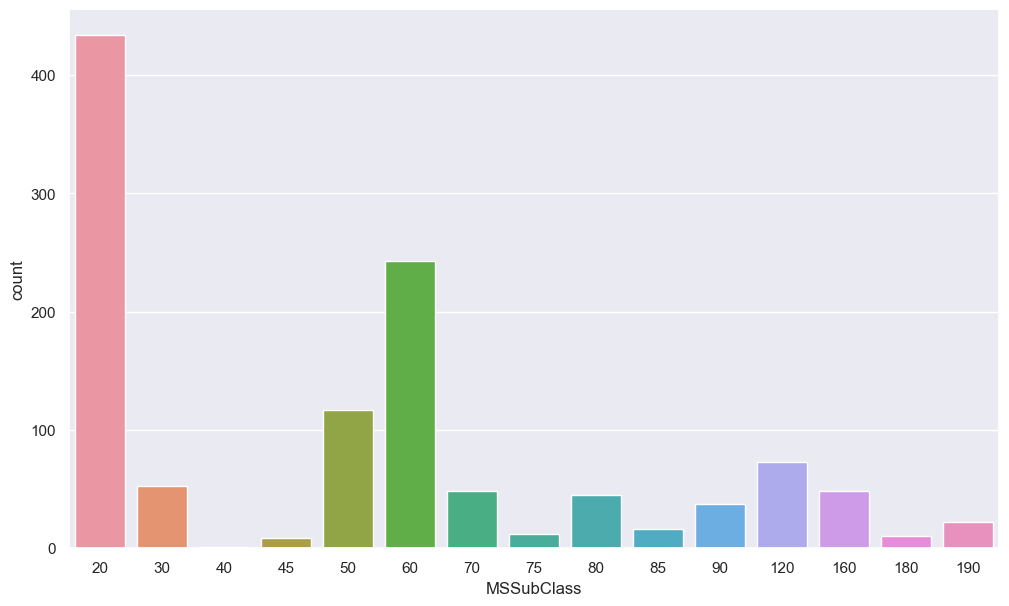

In [14]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['MSSubClass'])

# MSSubClass type 20 and 60 combinly contribute for around 57% of houses and type 40 contributes least

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='MSSubClass', ylabel='SalePrice'>

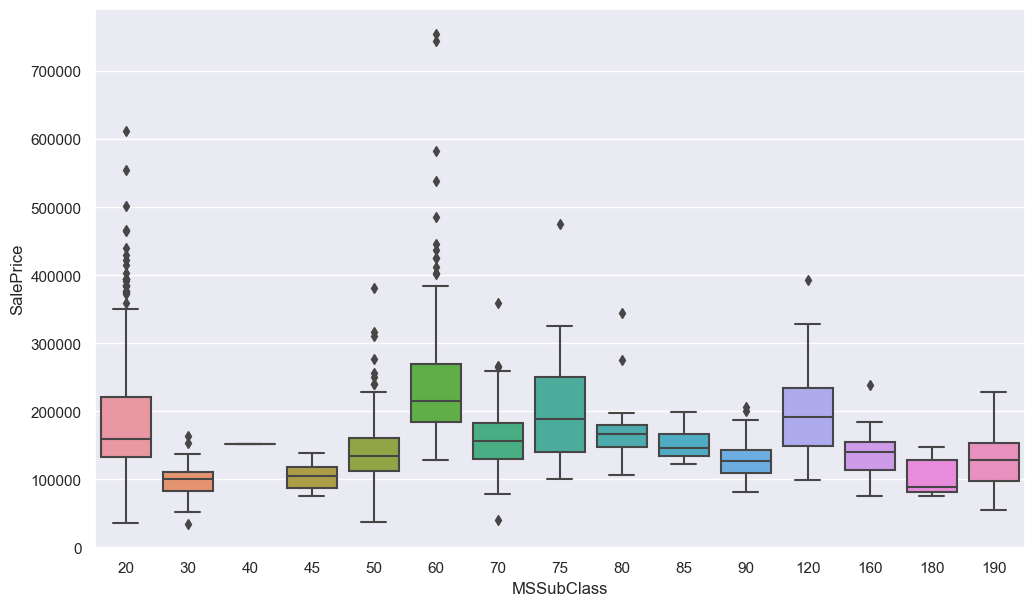

In [15]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.boxplot(x=X_train['MSSubClass'], y=Y_train['SalePrice'])

# MSSubClass type 60 are costliest house type and type 180, 30 and 45 are least

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='MSZoning', ylabel='count'>

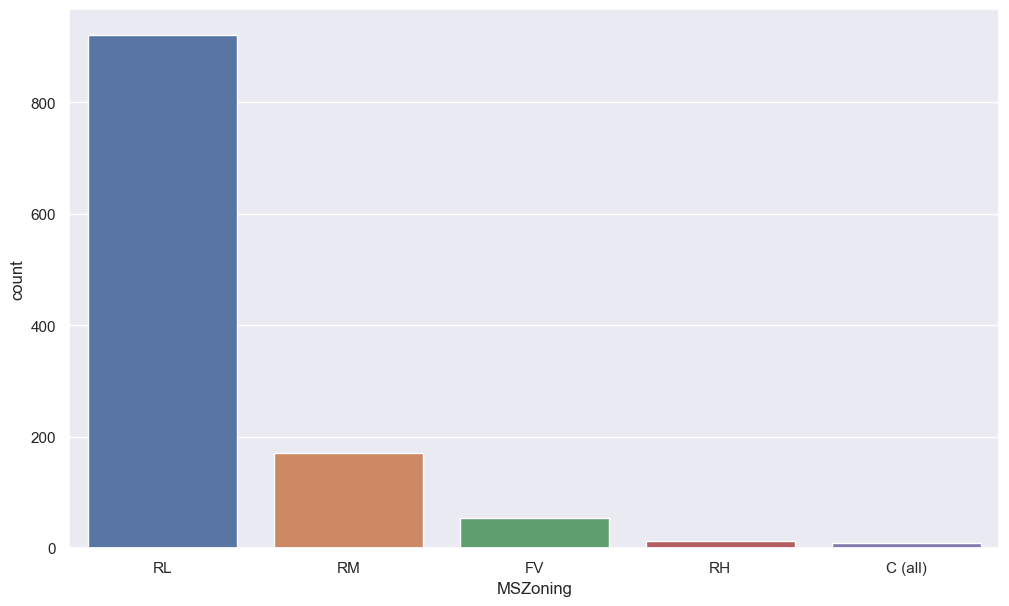

In [16]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['MSZoning'])

# House in zone RL accomodates around 78% of total houses

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='MSZoning', ylabel='SalePrice'>

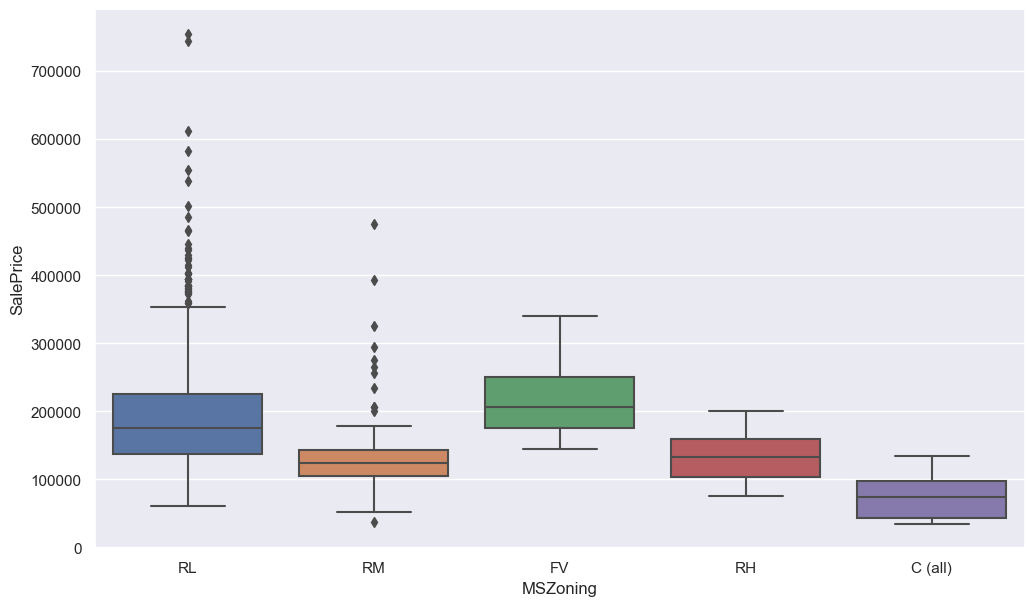

In [17]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.boxplot(x=X_train['MSZoning'], y=Y_train['SalePrice'])

# Houses in FV or Floating Village Residential zones are comparatively costlier than other zonal houses

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='Alley', ylabel='count'>

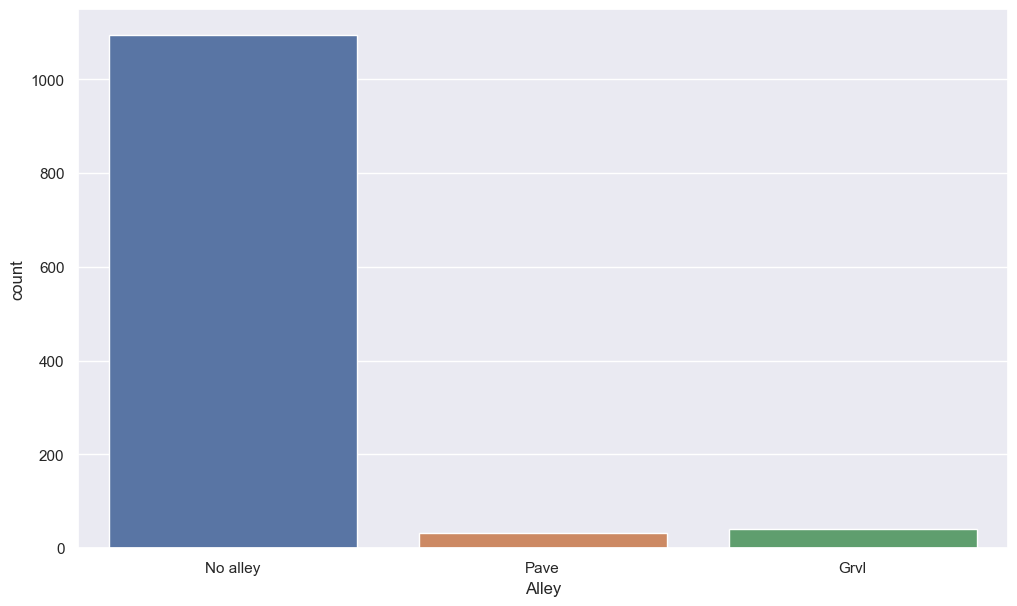

In [18]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['Alley'])

# Around 94% of houses don't have alley access

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='LotShape', ylabel='SalePrice'>

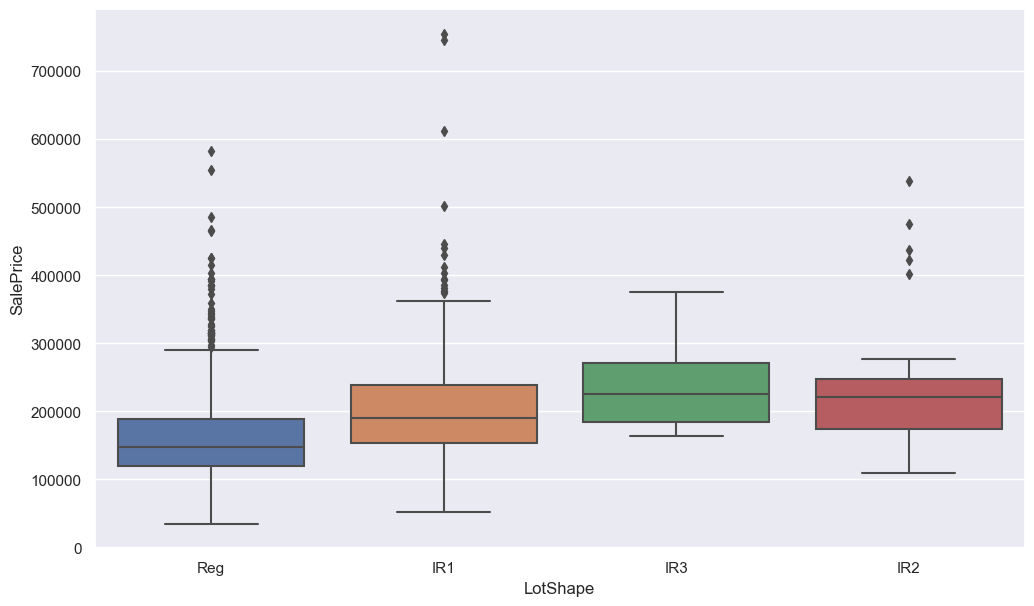

In [19]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.boxplot(x=X_train['LotShape'], y=Y_train['SalePrice'])

# Irregular shaped houses are costlier than regular shaped houses

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='LotShape', ylabel='count'>

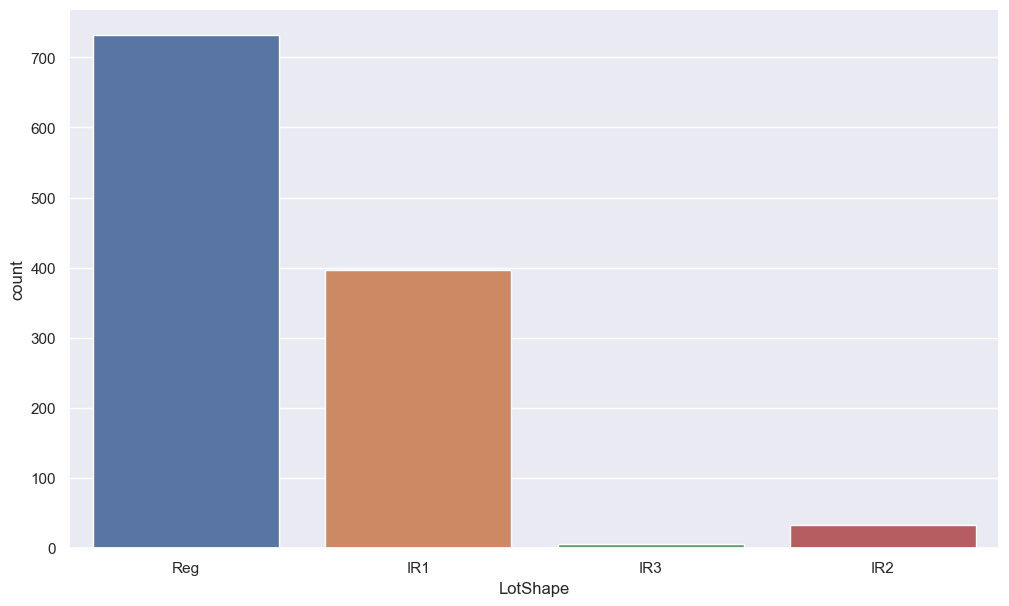

In [20]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['LotShape'])

# Around 63% of houses are of regular shape and around 0.5% of houses are of irregular shape (IR3)

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='LandContour', ylabel='SalePrice'>

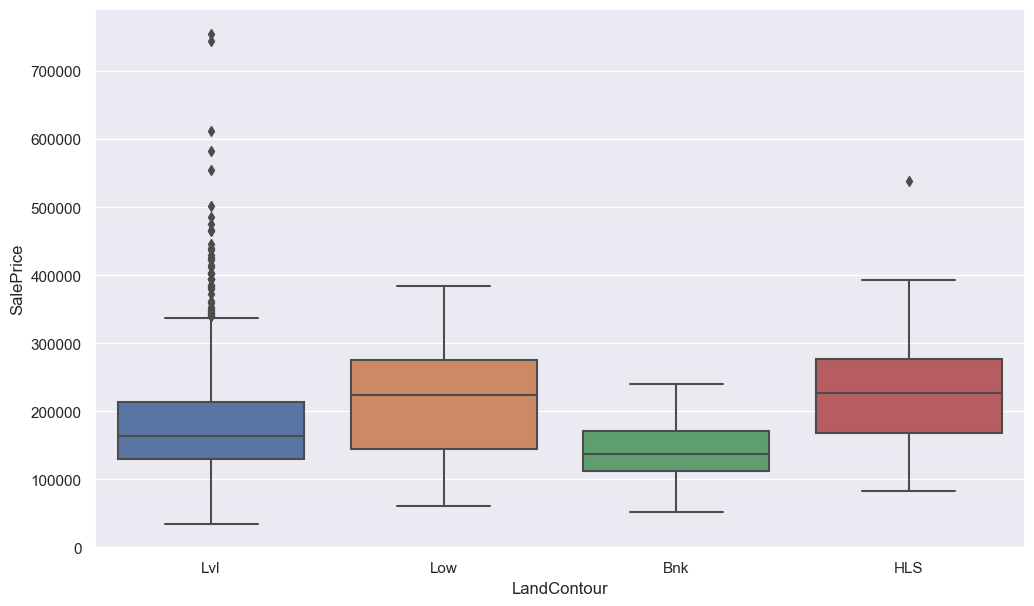

In [21]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.boxplot(x=X_train['LandContour'], y=Y_train['SalePrice'])

# Hillside and depressed houses are costlier than Banked and flat houses

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='LandContour', ylabel='count'>

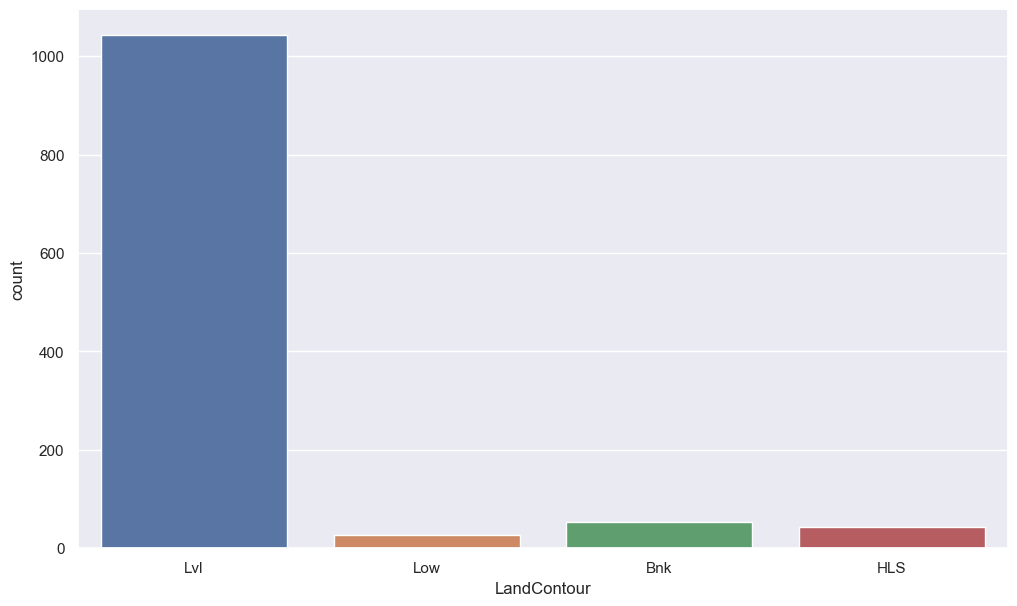

In [22]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['LandContour'])

# Around 90% of houses are nearly flat or leveled and around 2% of houses are in depressed area

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='LotConfig', ylabel='SalePrice'>

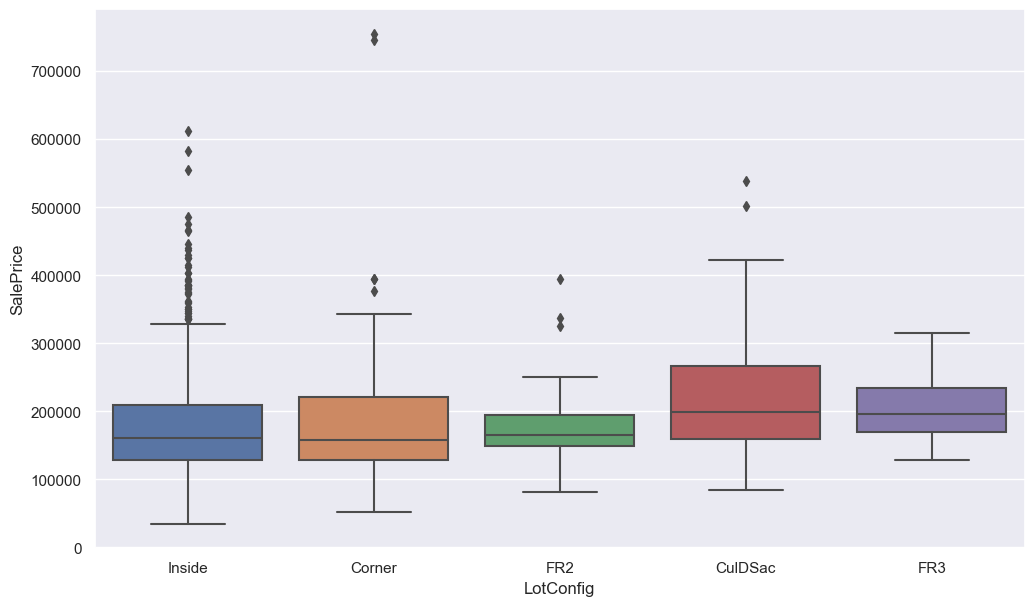

In [23]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.boxplot(x=X_train['LotConfig'], y=Y_train['SalePrice'])

# CulDSac and FR3 LotConfig houses are costler than other LotConfig houses

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='LotConfig', ylabel='count'>

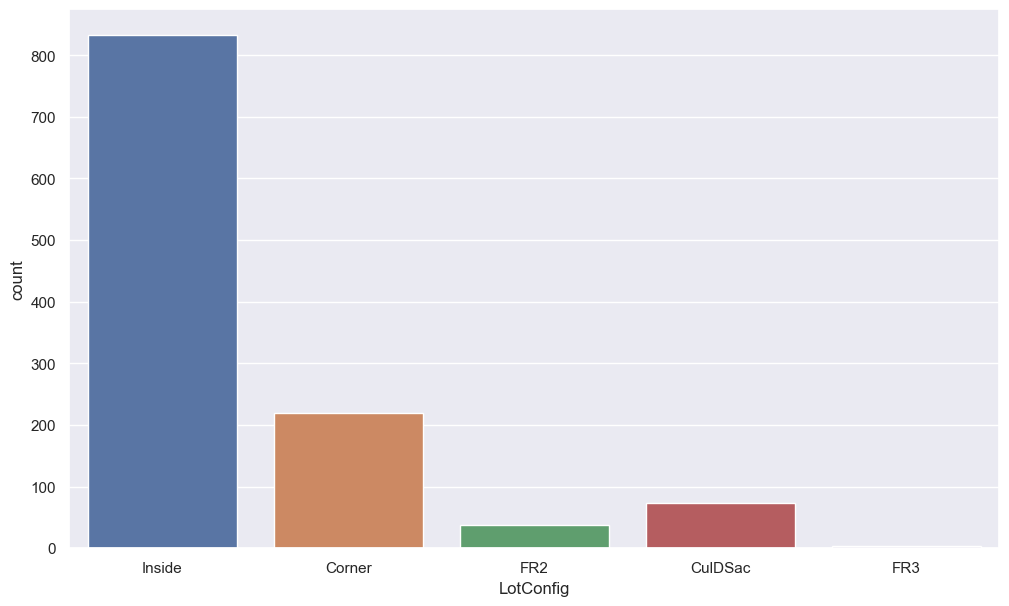

In [24]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['LotConfig'])

# 71% of the houses have inside lot, 18% on corners, 6%  on Cul-de-sac
# 0.3 % of houses have lot on 3 sides and 3% of houses have lot surrounded on 2 sides

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='LandSlope', ylabel='SalePrice'>

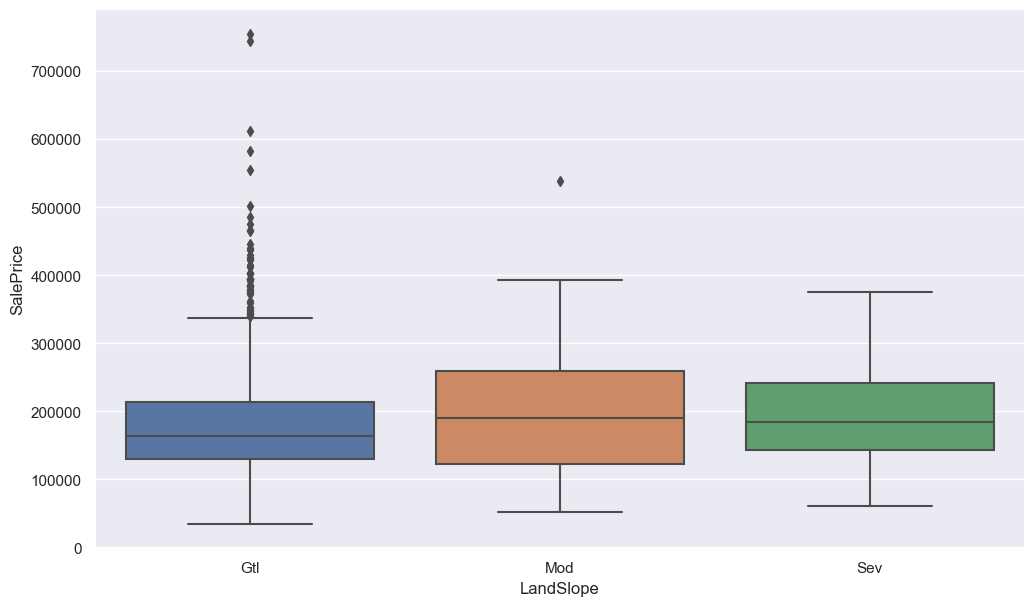

In [25]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.boxplot(x=X_train['LandSlope'], y=Y_train['SalePrice'])

# LandsSlope of the property/house doesn't affects the saleprice much

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='LandSlope', ylabel='count'>

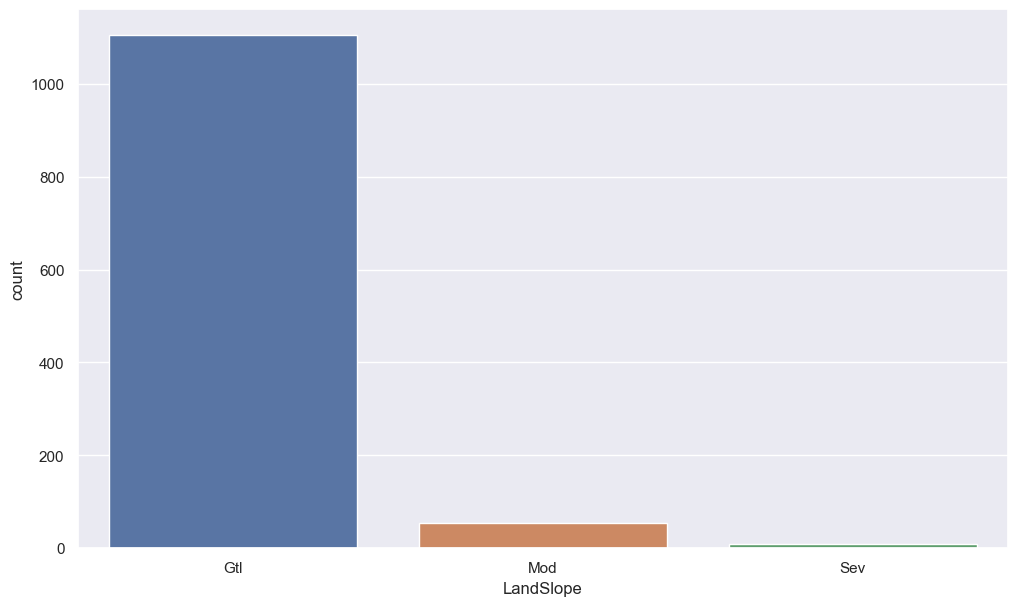

In [26]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['LandSlope'])

# Around 97% of the properties are on gentle sloped land where as 0.7% of the properties are on severe sloped land

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='Neighborhood', ylabel='SalePrice'>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'NAmes'),
  Text(1, 0, 'Mitchel'),
  Text(2, 0, 'ClearCr'),
  Text(3, 0, 'Edwards'),
  Text(4, 0, 'CollgCr'),
  Text(5, 0, 'BrkSide'),
  Text(6, 0, 'Somerst'),
  Text(7, 0, 'Timber'),
  Text(8, 0, 'NWAmes'),
  Text(9, 0, 'SWISU'),
  Text(10, 0, 'Gilbert'),
  Text(11, 0, 'SawyerW'),
  Text(12, 0, 'OldTown'),
  Text(13, 0, 'NridgHt'),
  Text(14, 0, 'MeadowV'),
  Text(15, 0, 'Crawfor'),
  Text(16, 0, 'NoRidge'),
  Text(17, 0, 'Sawyer'),
  Text(18, 0, 'Blueste'),
  Text(19, 0, 'IDOTRR'),
  Text(20, 0, 'Blmngtn'),
  Text(21, 0, 'BrDale'),
  Text(22, 0, 'NPkVill'),
  Text(23, 0, 'StoneBr'),
  Text(24, 0, 'Veenker')])

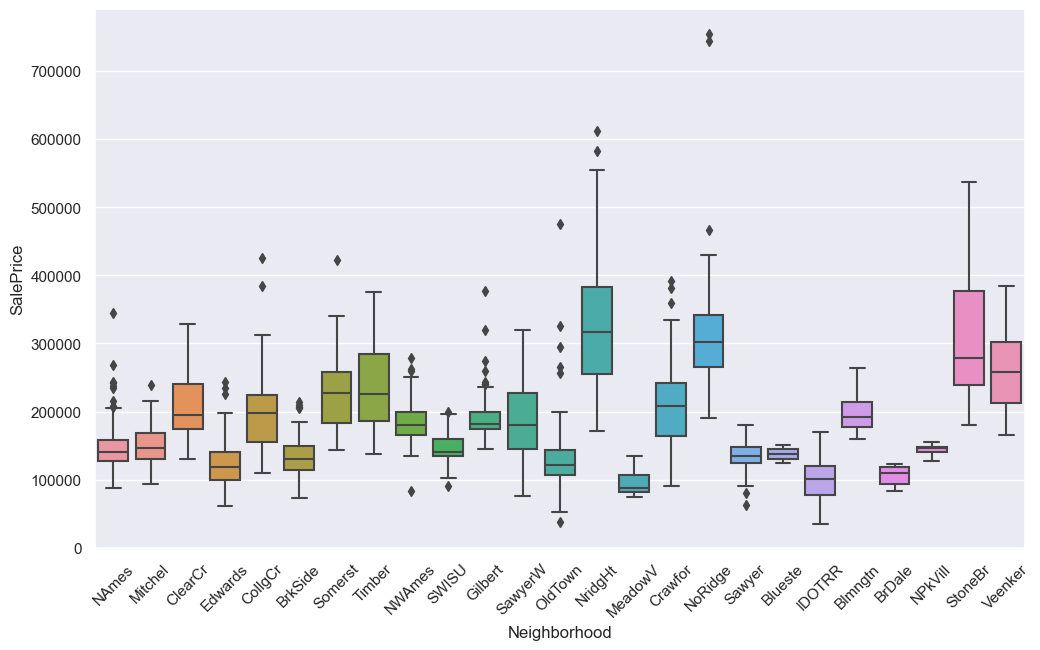

In [27]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.boxplot(x=X_train['Neighborhood'], y=Y_train['SalePrice'])
plt.xticks(rotation=45)

# Houses in Northridge Heights and Northridge location are costlier then other location within Ames city

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='Neighborhood', ylabel='count'>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'NAmes'),
  Text(1, 0, 'Mitchel'),
  Text(2, 0, 'ClearCr'),
  Text(3, 0, 'Edwards'),
  Text(4, 0, 'CollgCr'),
  Text(5, 0, 'BrkSide'),
  Text(6, 0, 'Somerst'),
  Text(7, 0, 'Timber'),
  Text(8, 0, 'NWAmes'),
  Text(9, 0, 'SWISU'),
  Text(10, 0, 'Gilbert'),
  Text(11, 0, 'SawyerW'),
  Text(12, 0, 'OldTown'),
  Text(13, 0, 'NridgHt'),
  Text(14, 0, 'MeadowV'),
  Text(15, 0, 'Crawfor'),
  Text(16, 0, 'NoRidge'),
  Text(17, 0, 'Sawyer'),
  Text(18, 0, 'Blueste'),
  Text(19, 0, 'IDOTRR'),
  Text(20, 0, 'Blmngtn'),
  Text(21, 0, 'BrDale'),
  Text(22, 0, 'NPkVill'),
  Text(23, 0, 'StoneBr'),
  Text(24, 0, 'Veenker')])

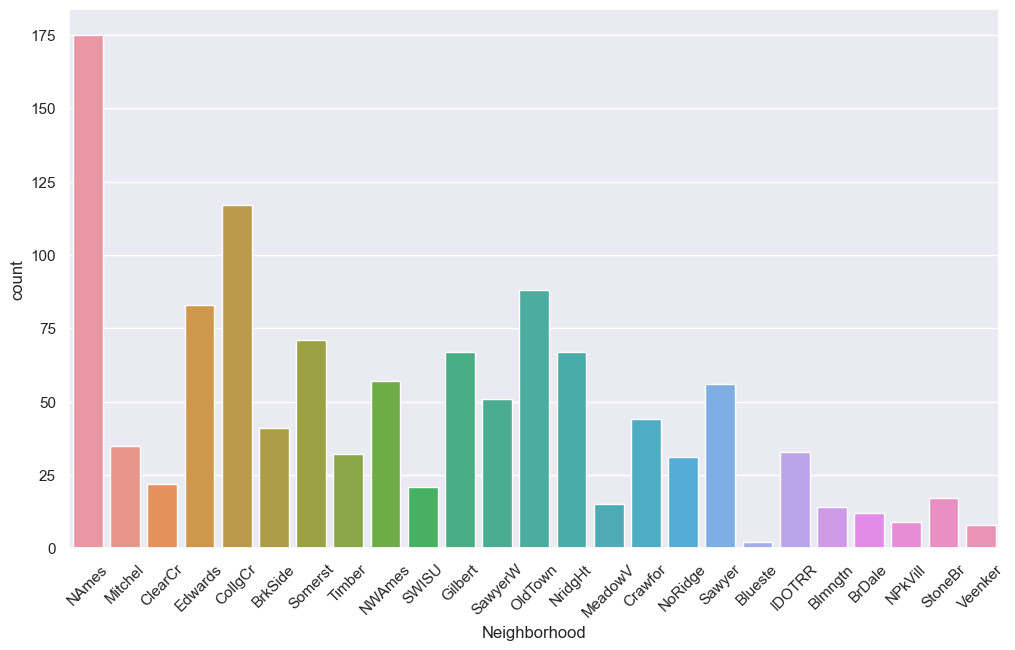

In [28]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['Neighborhood'])
plt.xticks(rotation=45)

# Around 15% (highest) of houses are in North Ames and 0.17% of houses are in bluestem areas.
# These two are among the cheapest areas of Ames city

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='HouseStyle', ylabel='SalePrice'>

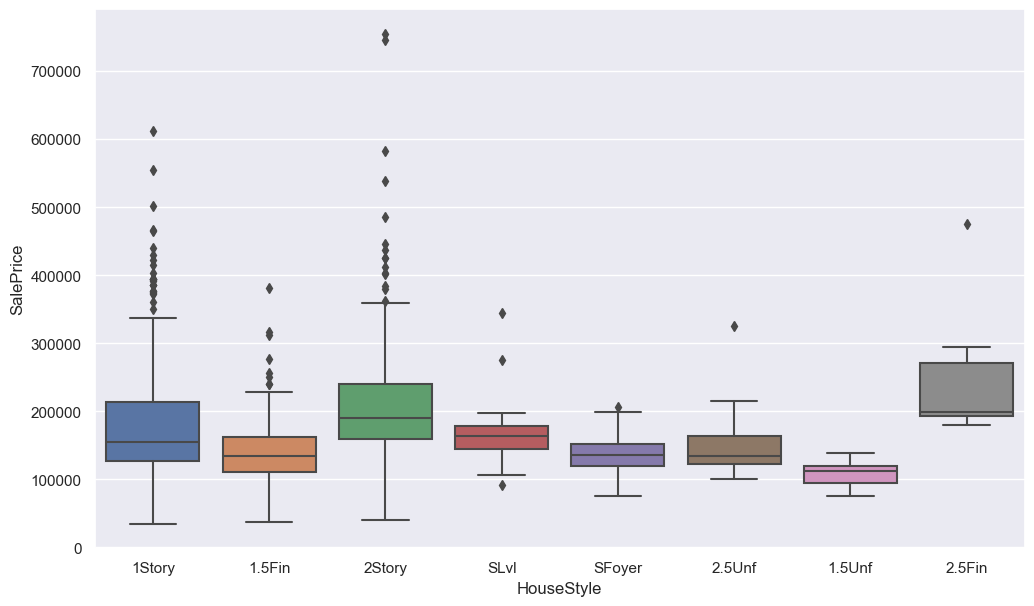

In [29]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.boxplot(x=X_train['HouseStyle'], y=Y_train['SalePrice'])

# 2Story and 2.5Fin HouseStyle are the costlier than other HouseStyle

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='HouseStyle', ylabel='count'>

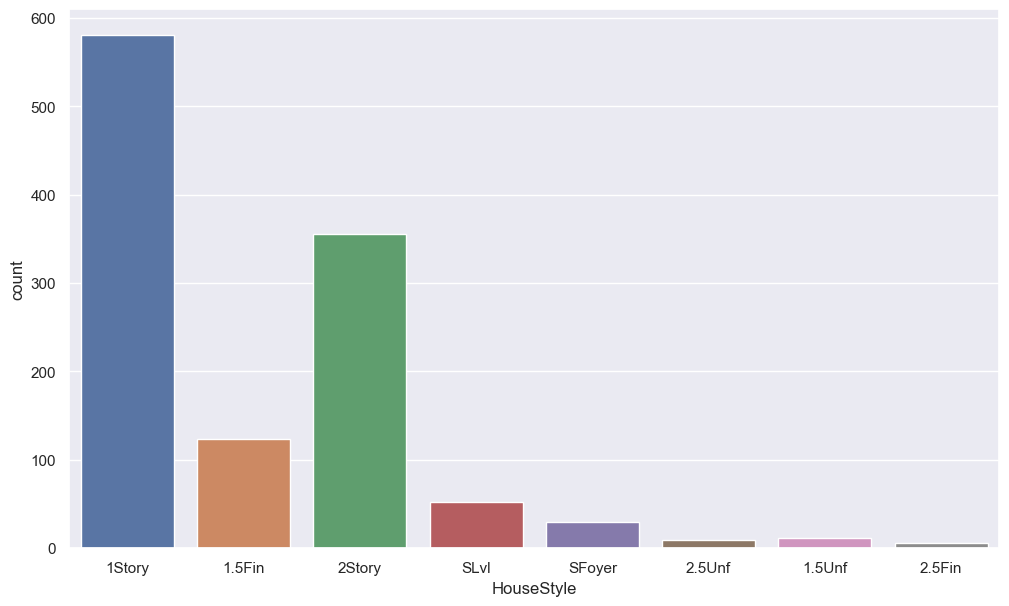

In [30]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['HouseStyle'])

# 1Story and 2Story HouseStyle contributes around 80% of all properties

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='OverallQual', ylabel='SalePrice'>

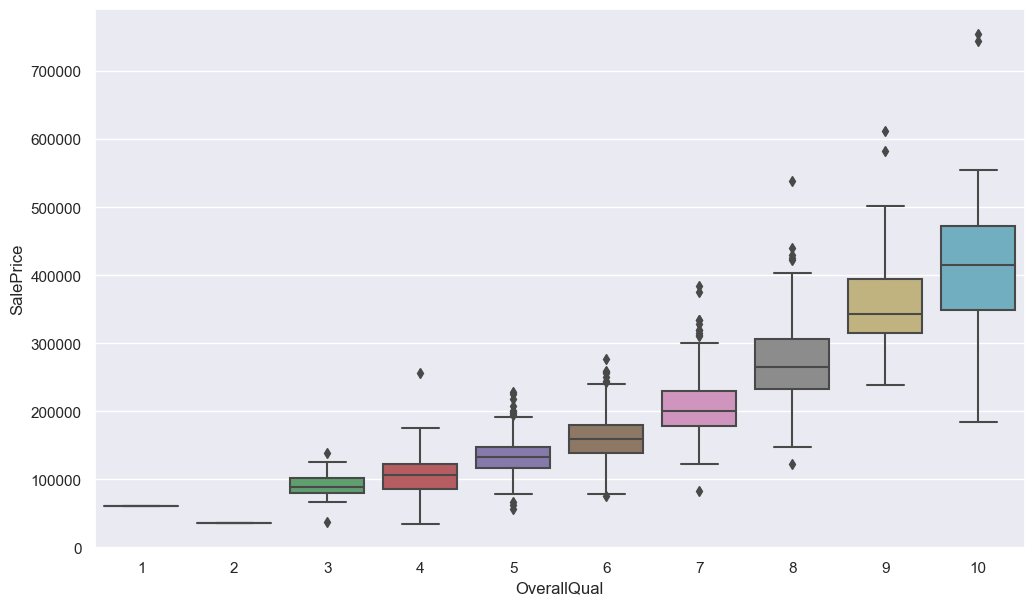

In [31]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.boxplot(x=X_train['OverallQual'], y=Y_train['SalePrice'])

# SalePrice increase as the OverallQual of the house improves (general trend)

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='OverallQual', ylabel='count'>

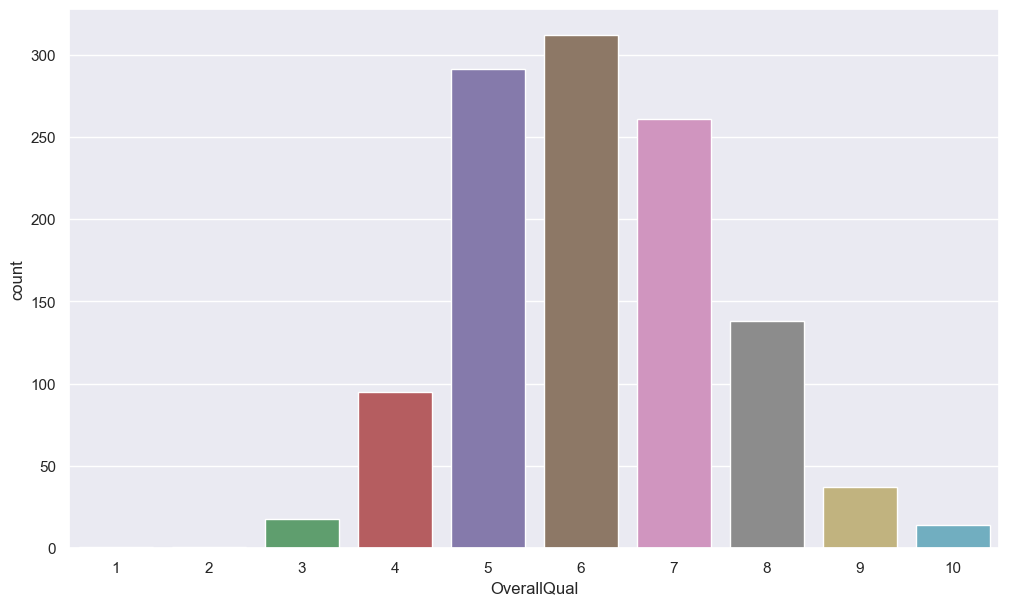

In [32]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['OverallQual'])

# Properties with OverallQual 5, 6 or 7 contributes towards 72% of total properties

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='ExterQual', ylabel='SalePrice'>

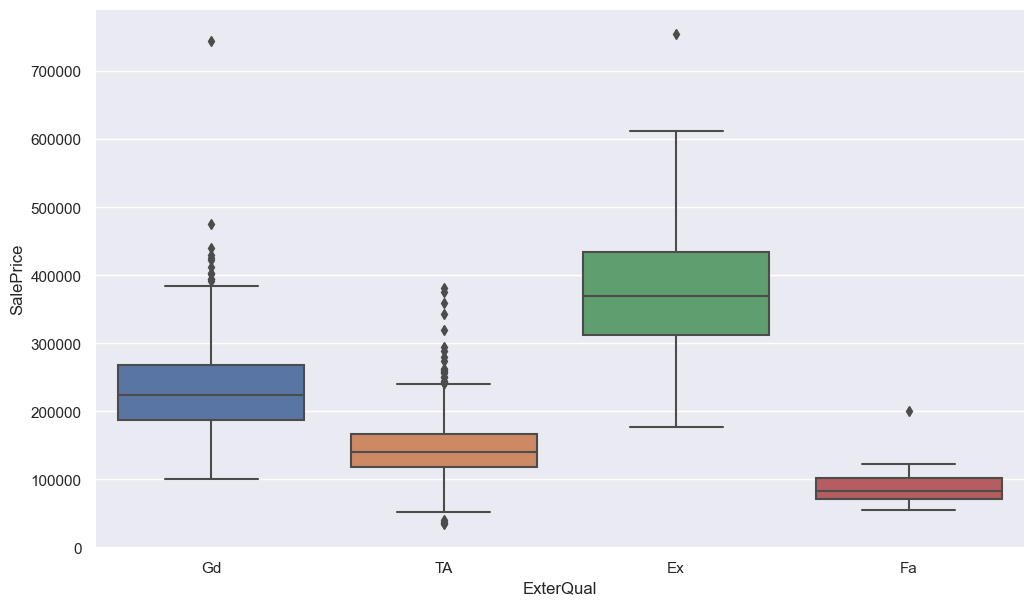

In [33]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.boxplot(x=X_train['ExterQual'], y=Y_train['SalePrice'])

# ExterQual of the properties greatly affects the SalePrice, Ex (excellent being the highest)

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='ExterQual', ylabel='count'>

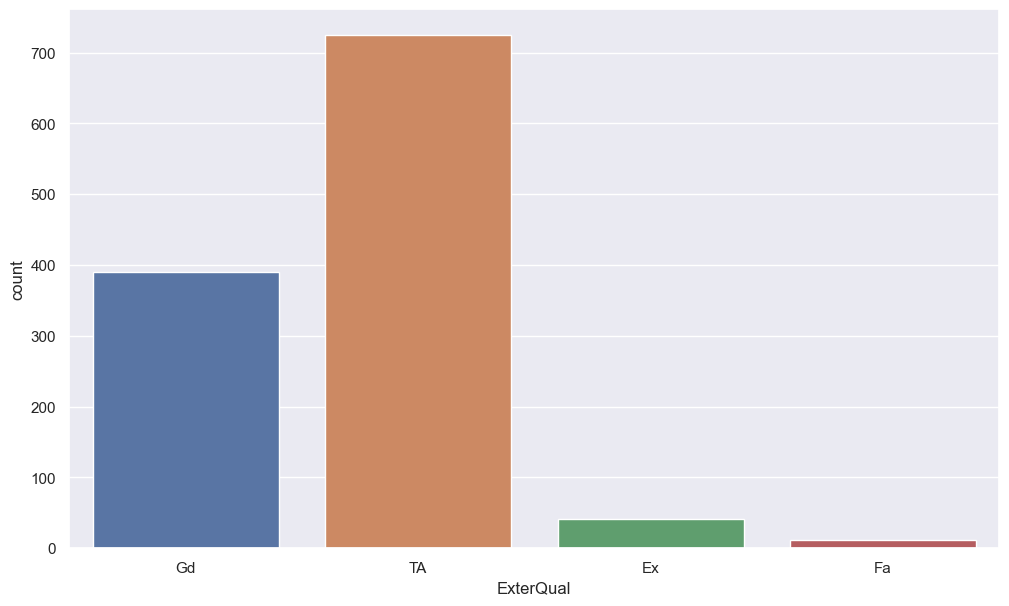

In [34]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['ExterQual'])

# 95% of the properties have TA (Average or Typical) or Gd (Good) ExterQual rating
# Ex (Excellent) being the costliest, contribute only 3.5% towards total no of properties

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='BsmtQual', ylabel='SalePrice'>

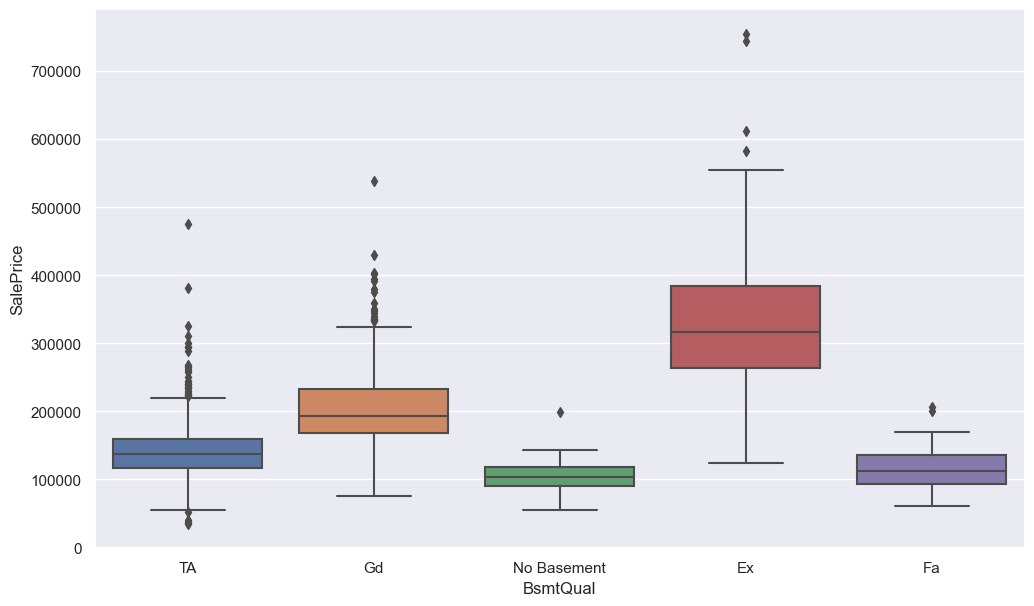

In [35]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.boxplot(x=X_train['BsmtQual'], y=Y_train['SalePrice'])

# BsmtQual greatly affects the SalePrice of the properties
# Properties with Ex (excellent) BsmtQual are costliest

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='BsmtQual', ylabel='count'>

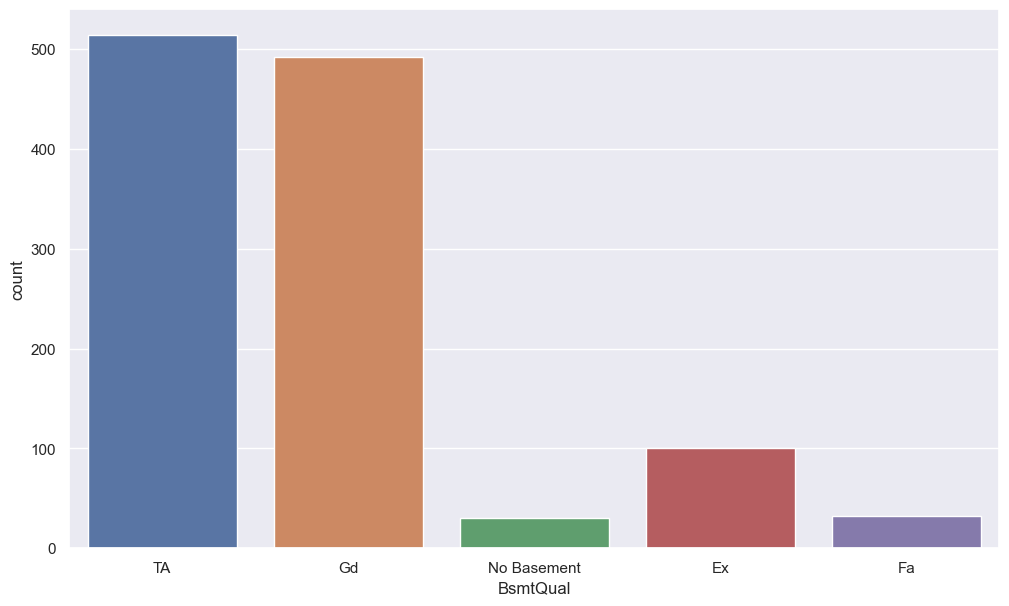

In [36]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['BsmtQual'])

# Properties with TA and Gd BsmtQual makes 86% of total properties
# 2.5% of properties doen't have any basement

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='BsmtExposure', ylabel='count'>

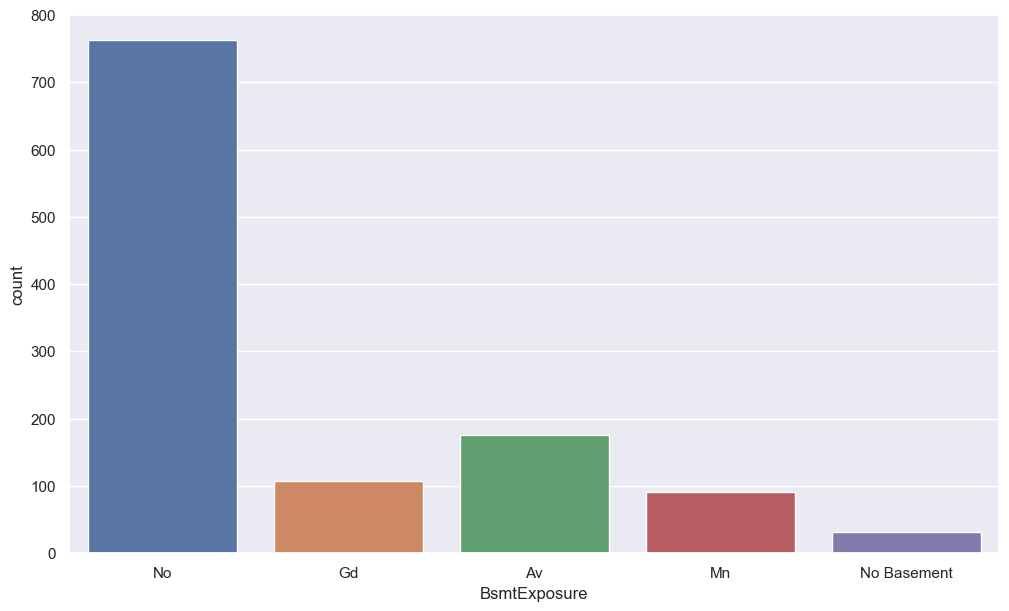

In [37]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['BsmtExposure'])

# 65% of properties don't have bsmtExposure

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='KitchenQual', ylabel='SalePrice'>

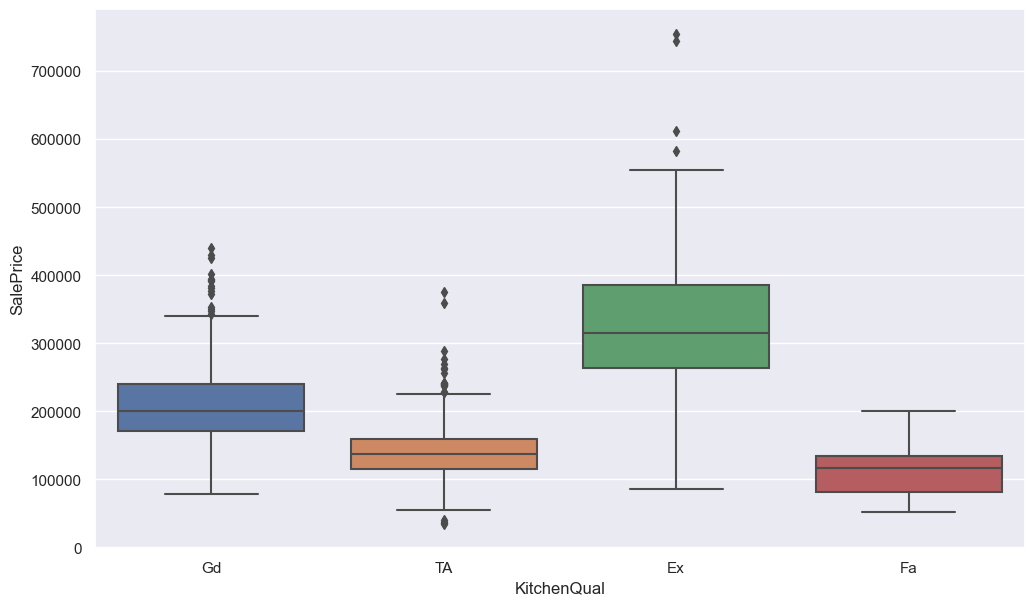

In [38]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.boxplot(x=X_train['KitchenQual'], y=Y_train['SalePrice'])

# Houses with Excellent Kitchen QUality are costliest

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='KitchenQual', ylabel='count'>

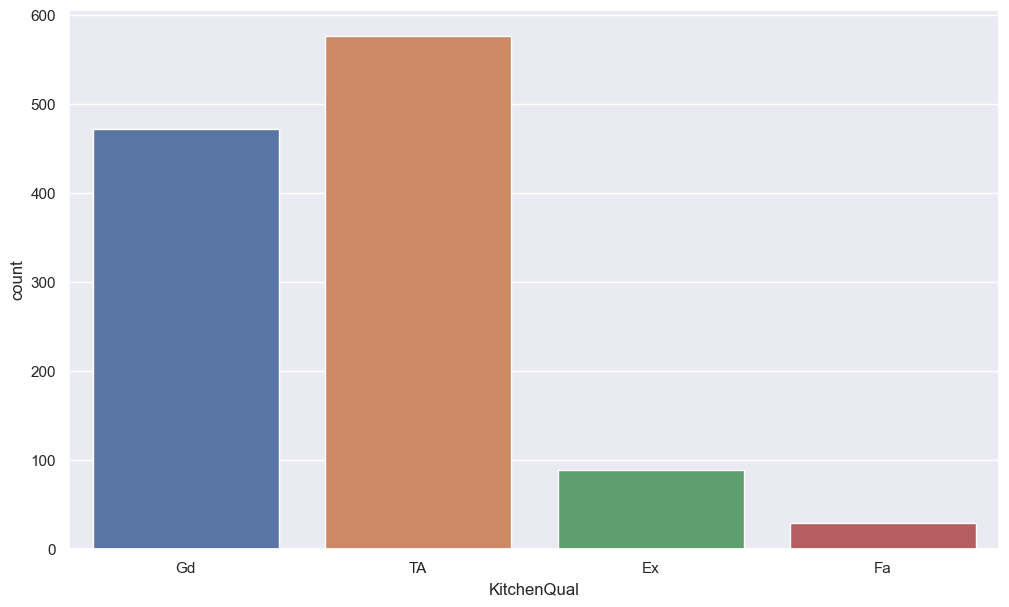

In [39]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['KitchenQual'])

# Around 90% of the houses have KitchenQual of TA or Gd
# 7.6% of the properties have excellent Kitchen Quality

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='GarageType', ylabel='SalePrice'>

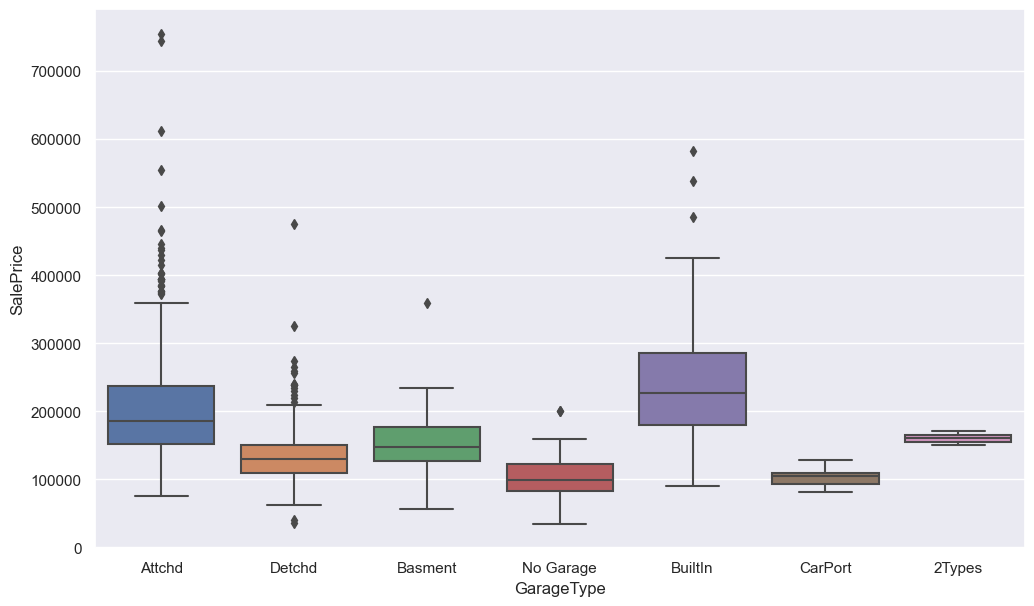

In [40]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.boxplot(x=X_train['GarageType'], y=Y_train['SalePrice'])

# Houses with built-in garage type are costliest

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='GarageType', ylabel='count'>

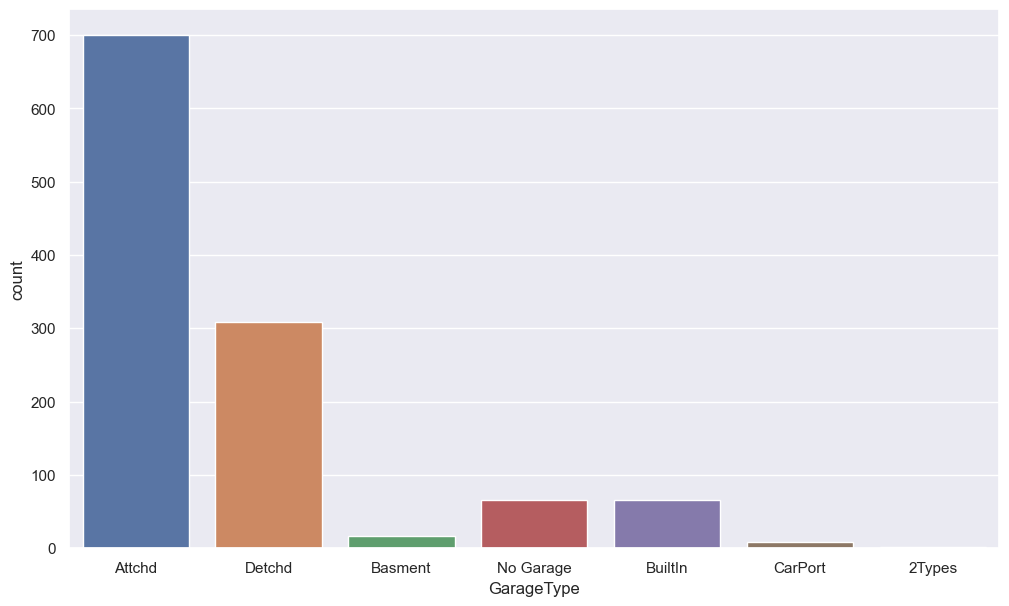

In [41]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['GarageType'])

# 59% of the houses have attached Garage type.
# Around 6% of the houses don't have garage

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='Fence', ylabel='count'>

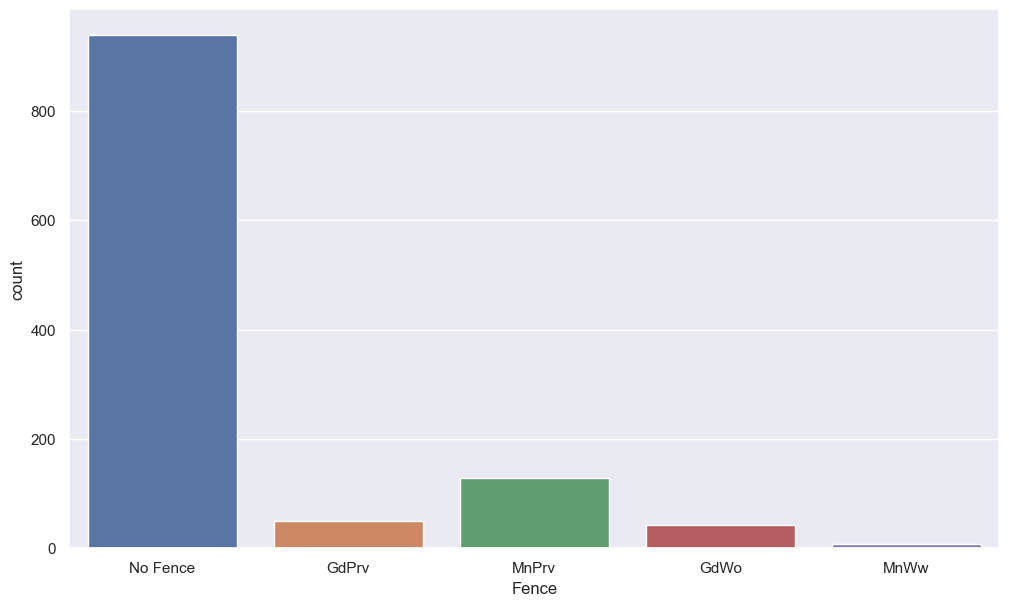

In [42]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['Fence'])

# Around 80% of the houses don't have any fence

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='YrSold', ylabel='count'>

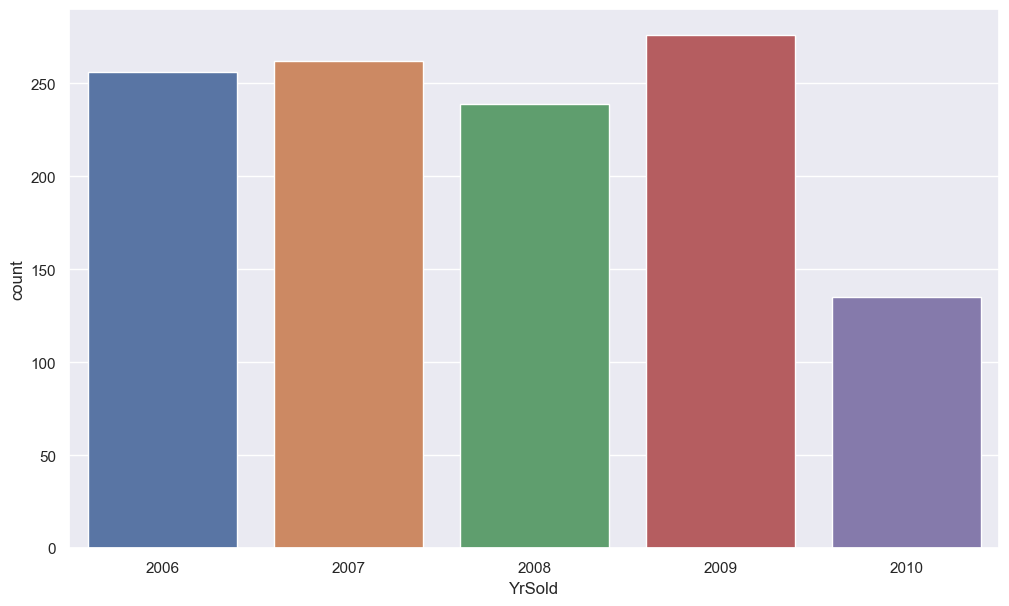

In [43]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['YrSold'])

# Least houses are sold in 2010, around 11.5%

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='SaleType', ylabel='SalePrice'>

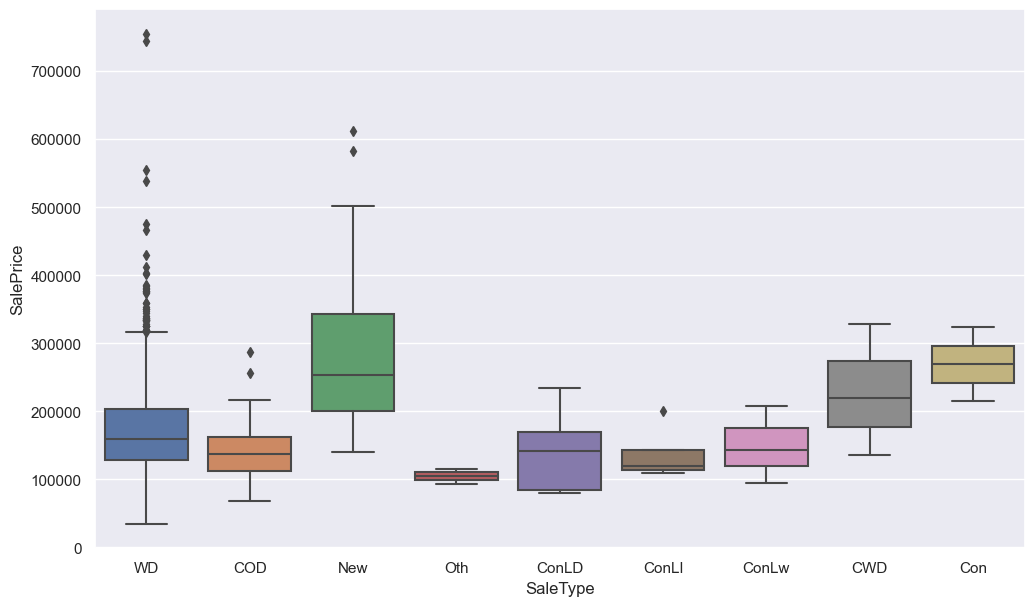

In [44]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.boxplot(x=X_train['SaleType'], y=Y_train['SalePrice'])

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='SaleCondition', ylabel='count'>

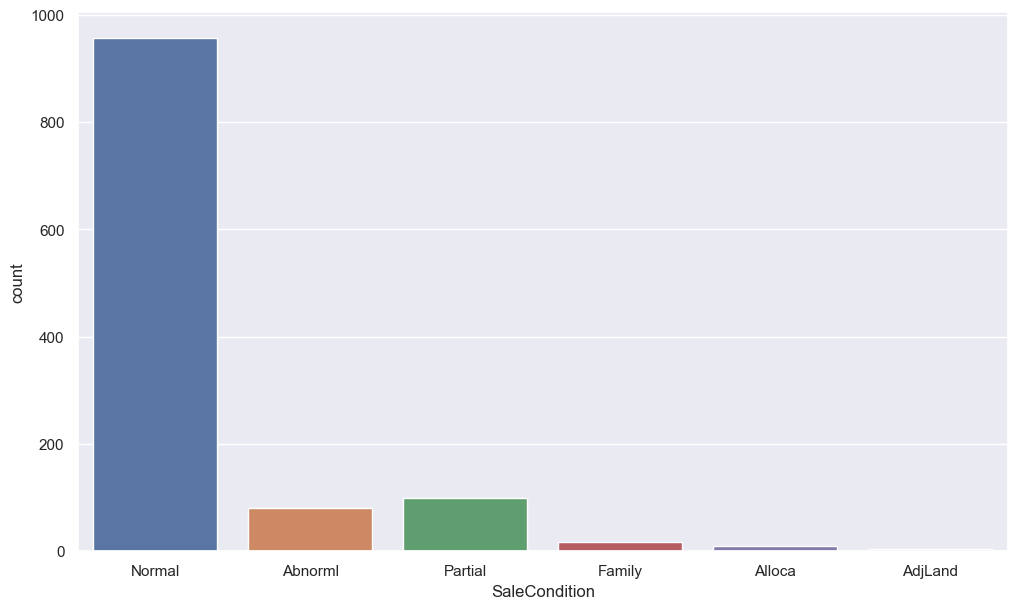

In [45]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['SaleCondition'])

# Around 90% of properties are sold normally

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='SaleCondition', ylabel='SalePrice'>

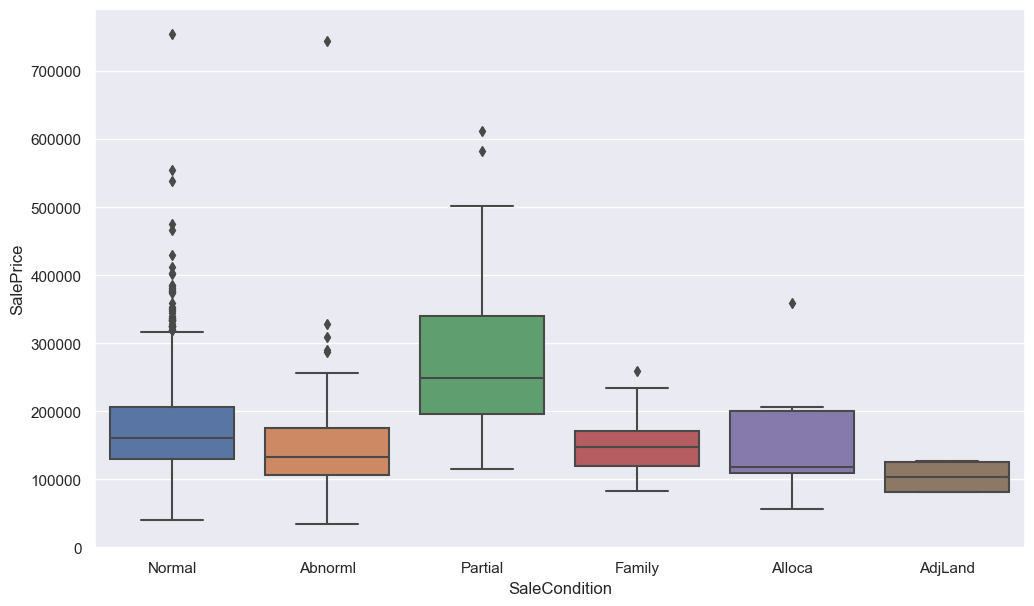

In [46]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.boxplot(x=X_train['SaleCondition'], y=Y_train['SalePrice'])

# Houses which are sold before the final completetion are costliest.

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='YearBuilt', ylabel='SalePrice'>

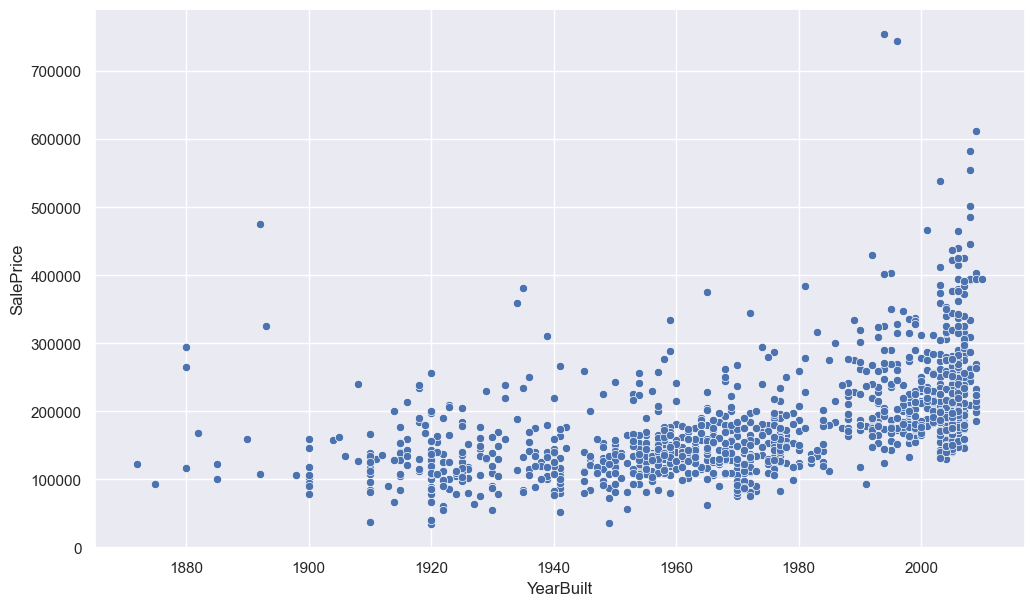

In [47]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.scatterplot(x=X_train['YearBuilt'], y=Y_train['SalePrice'])

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='FullBath', ylabel='count'>

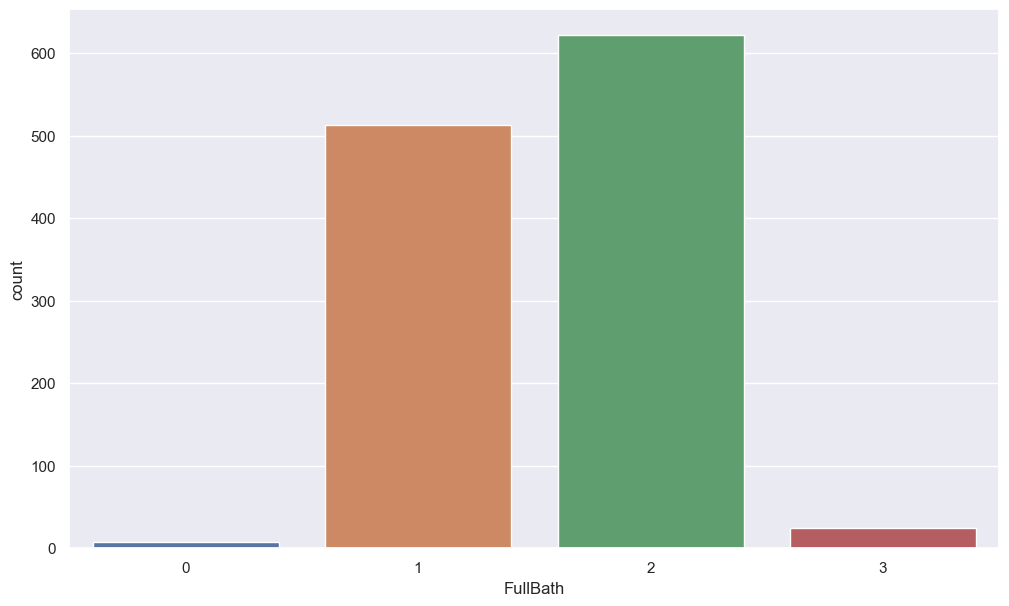

In [48]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['FullBath'])

# 53% and 44% of properties have 2 and 1 Full bathrooms respectively

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='FullBath', ylabel='SalePrice'>

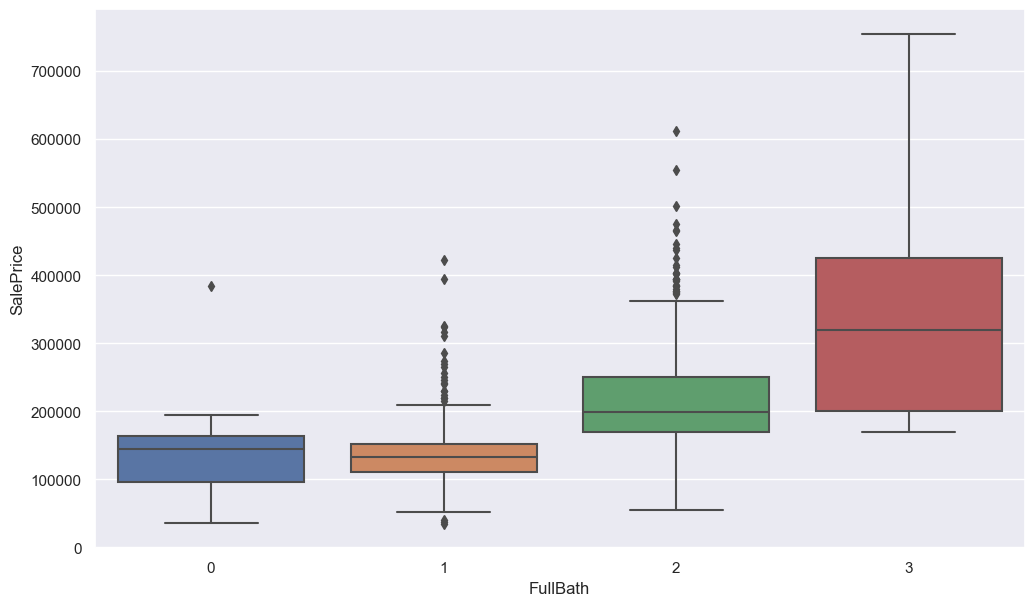

In [49]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.boxplot(x=X_train['FullBath'], y=Y_train['SalePrice'])

# Saleprice for properties with 0 & 1 FullBath is nearly the same. But id increasing remarkably for 2 and 3 FullBath

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='YearRemodAdd', ylabel='SalePrice'>

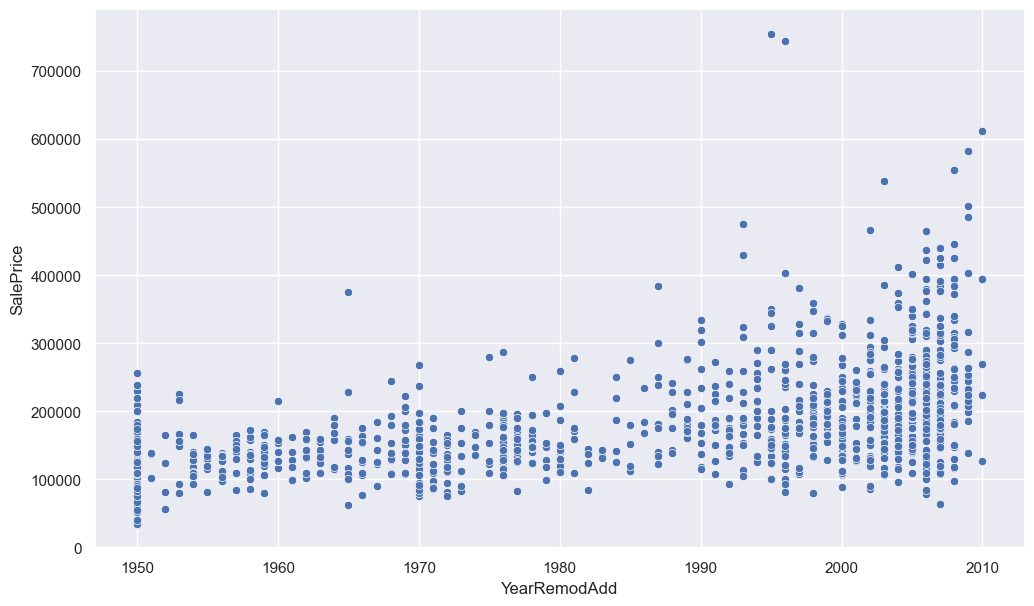

In [50]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.scatterplot(x=X_train['YearRemodAdd'], y=Y_train['SalePrice'])

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

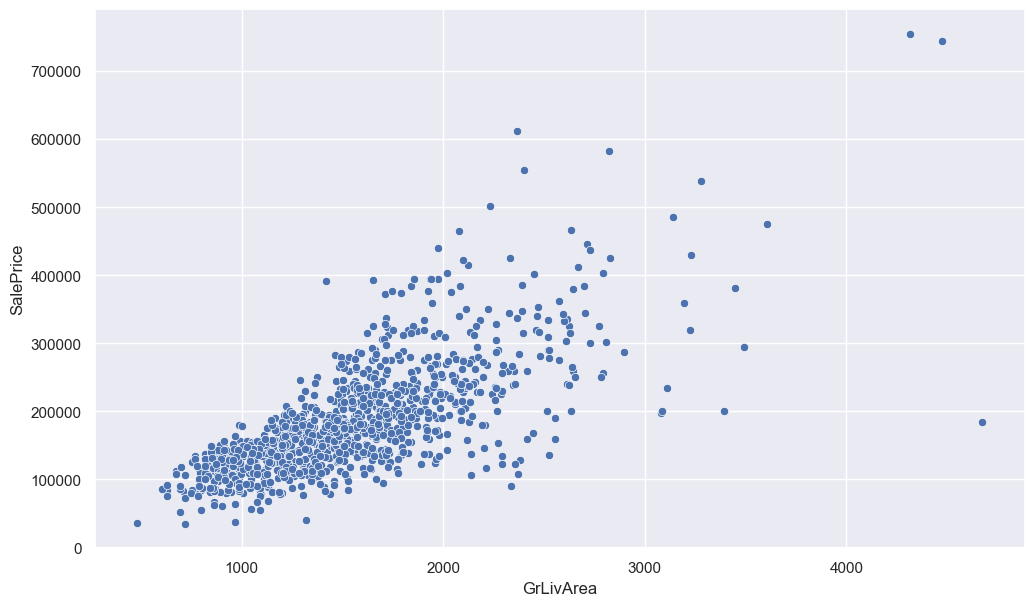

In [51]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.scatterplot(x=X_train['GrLivArea'], y=Y_train['SalePrice'])

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='TotRmsAbvGrd', ylabel='SalePrice'>

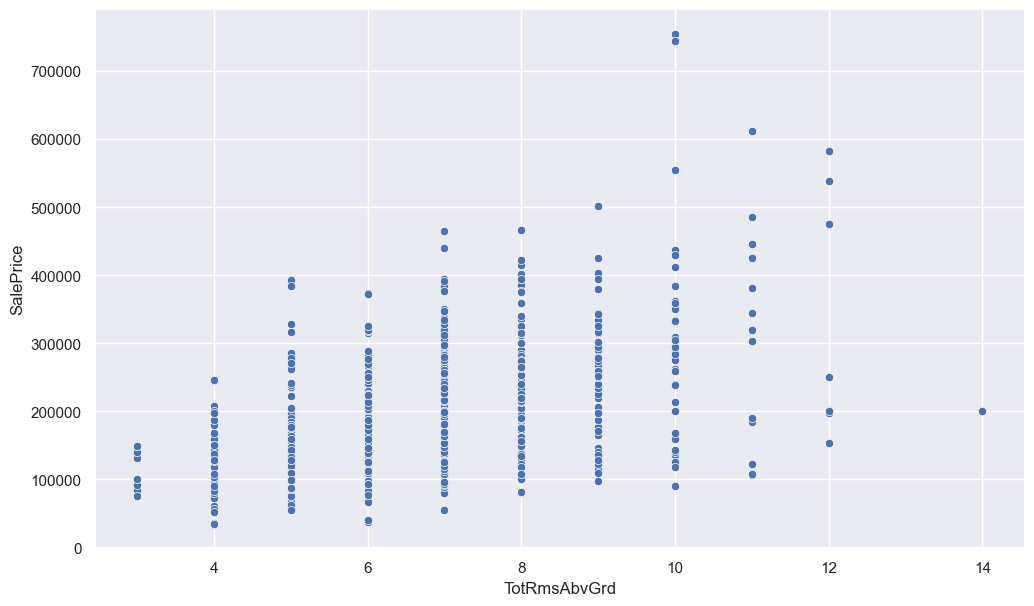

In [52]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.scatterplot(x=X_train['TotRmsAbvGrd'], y=Y_train['SalePrice'])

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='TotRmsAbvGrd', ylabel='count'>

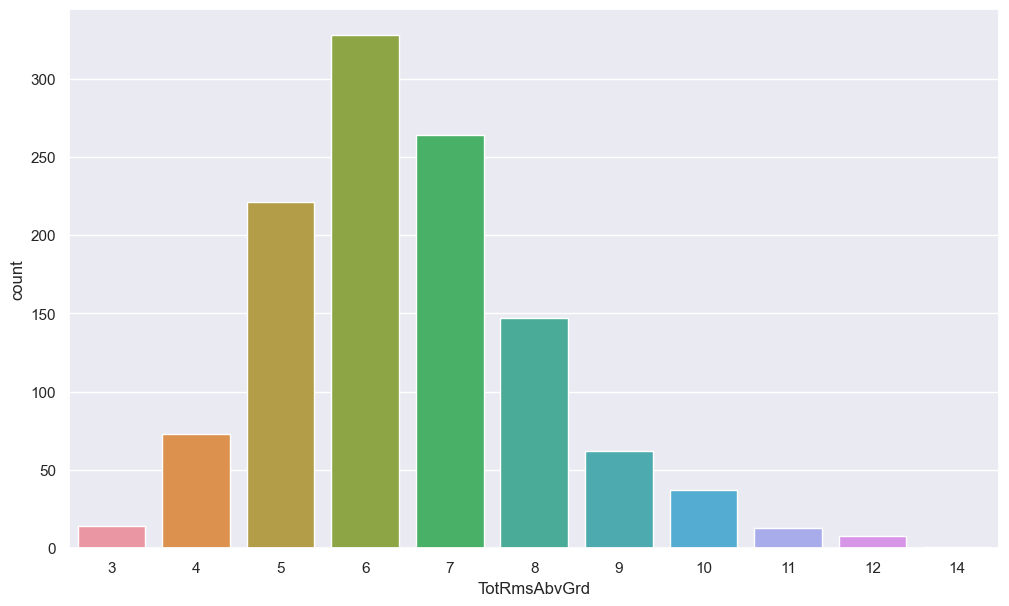

In [53]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['TotRmsAbvGrd'])

# 28% of the houses have 6 bedroome, 22% have 7 bedrooms

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='GarageCars', ylabel='count'>

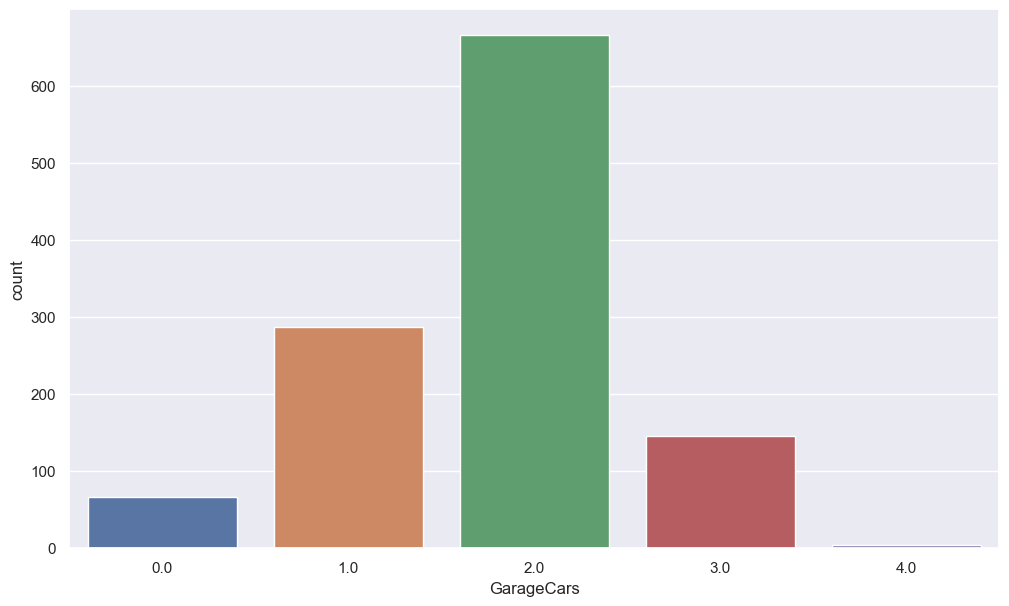

In [54]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['GarageCars'])

# 57% of the Garage have capacity of dtoring 2 cars
# 0.3# Houses don't have any Garage

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='GarageArea', ylabel='SalePrice'>

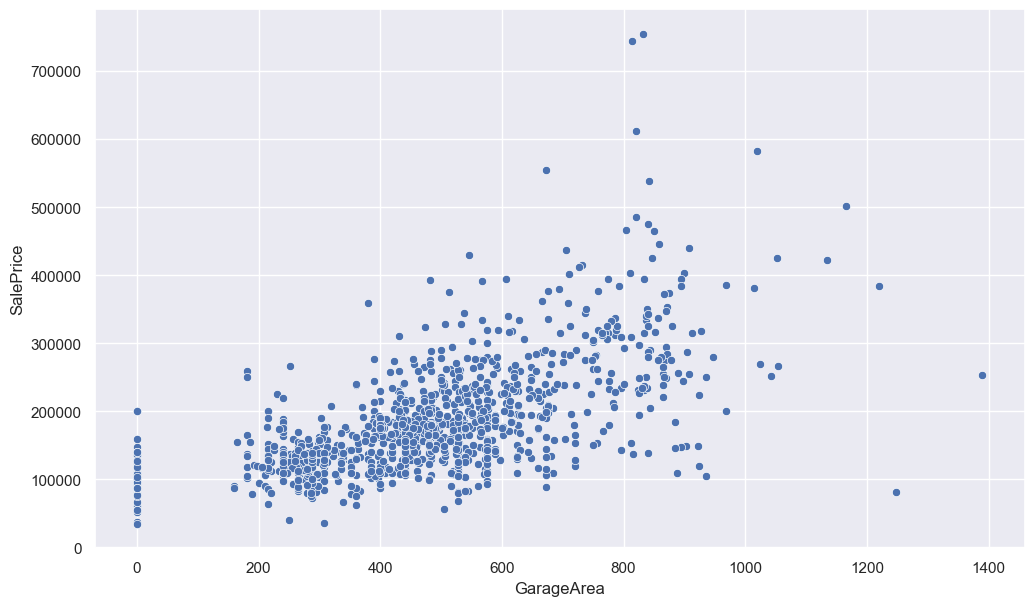

In [55]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.scatterplot(x=X_train['GarageArea'], y=Y_train['SalePrice'])

# SalePrice of the properties increases as GarageArea increases

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='YrSold', ylabel='count'>

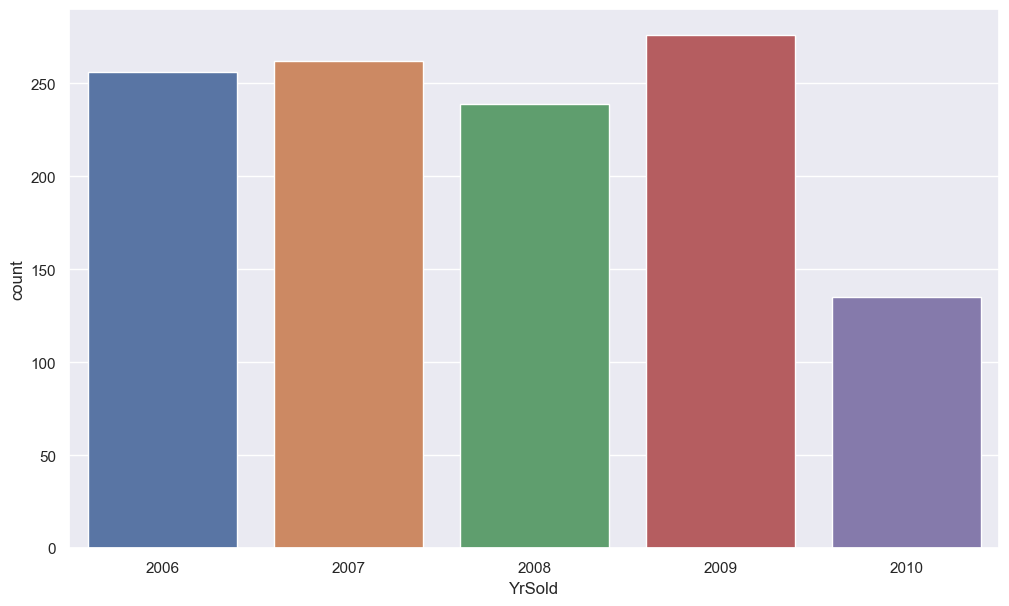

In [56]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['YrSold'])

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='YrSold', ylabel='SalePrice'>

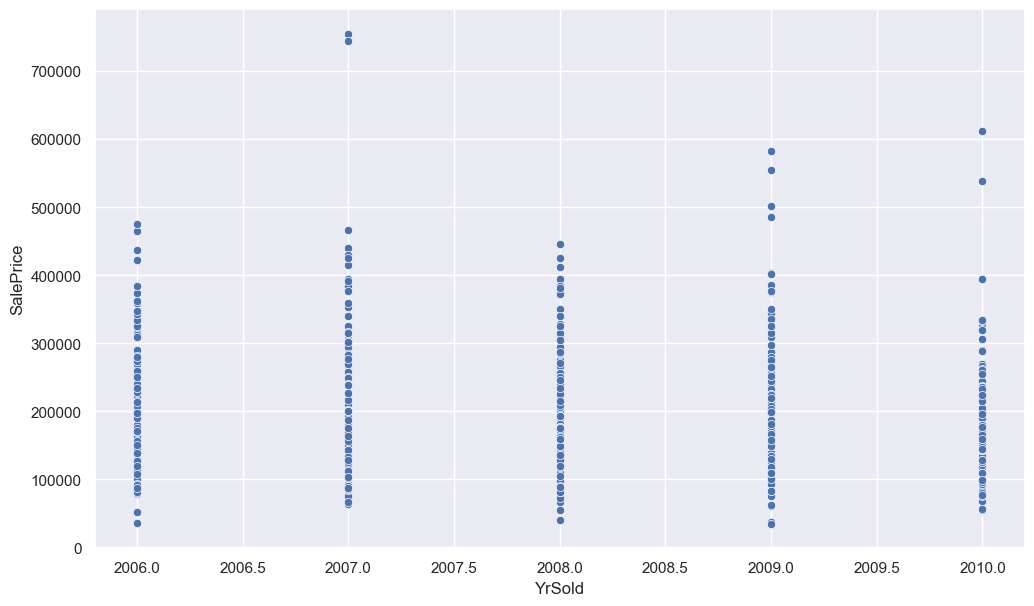

In [57]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.scatterplot(x=X_train['YrSold'], y=Y_train['SalePrice'])

# SalePrice of the properties looks independent of Year Sold

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='YrSold', ylabel='count'>

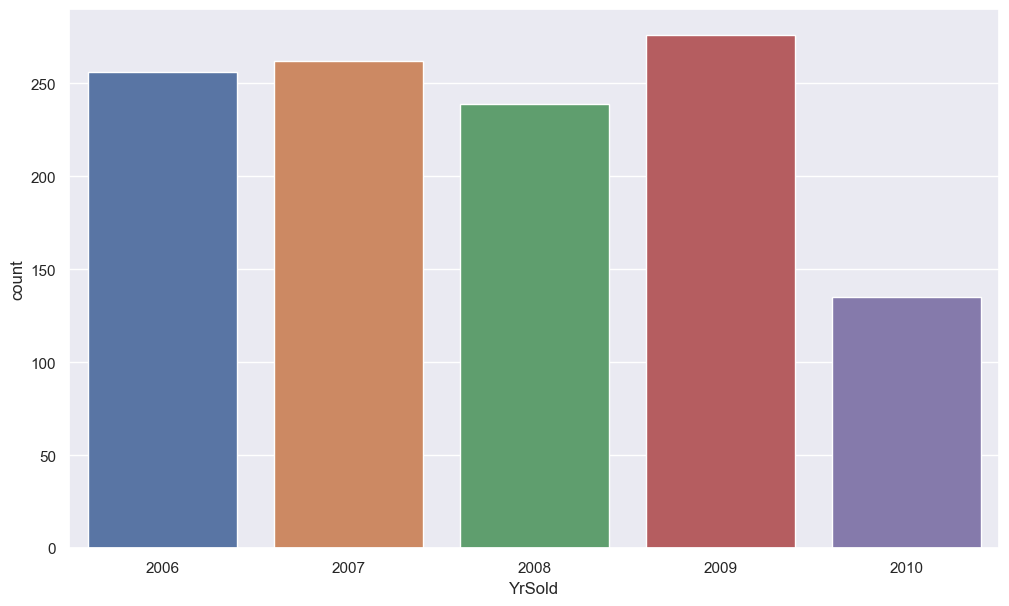

In [58]:
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
sns.countplot(x=X_train['YrSold'])

## Encoding categorical features of training data 

In [59]:
## Some categories of Exterior2nd feature are wrongly spelled like BrkComm as Brk Cmn, CemntBd as CmentBd, etc. 

X_train['Exterior2nd'].replace(to_replace='Brk Cmn', value='BrkComm', inplace=True)
X_train['Exterior2nd'].replace(to_replace='CmentBd', value='CemntBd', inplace=True)
X_train['Exterior2nd'].replace(to_replace='Wd Shng', value='Wd Sdng', inplace=True)

### Feature encoding for categorical features

In [60]:
# Training/fitting categorical encoder

cat_features = X_train.select_dtypes(include='object').columns.to_list()
encoder = ModelPreprocessing.fit_cat_encoder(X_train[cat_features])

In [61]:
# Transforming categorical features of training data

X_train[cat_features] = encoder.transform(X_train[cat_features])
X_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
485,486,20,4.0,80.0,9600,1.0,2.0,3.0,3.0,3.0,4.0,2.0,24.0,8.0,8.0,4.0,7.0,5,7,1950,2007,5.0,7.0,13.0,13.0,4.0,0.0,4.0,4.0,4.0,3.0,3.0,1.0,5.0,607,1.0,0,506,1113,5.0,3.0,1.0,4.0,1113,0,0,1113,0,0,1,0,3,1,3.0,5,7.0,1,4.0,6.0,1950.0,1.0,1.0,264.0,3.0,3.0,2.0,0,80,120,0,0,0,0.0,4.0,5.0,0,7,2009,9.0,5.0
274,275,20,4.0,76.0,8314,1.0,2.0,3.0,3.0,3.0,3.0,2.0,12.0,8.0,8.0,4.0,7.0,5,7,1982,1982,5.0,7.0,15.0,4.0,4.0,0.0,2.0,4.0,4.0,3.0,3.0,4.0,5.0,546,1.0,0,270,816,5.0,2.0,1.0,4.0,816,0,0,816,0,0,1,0,2,1,2.0,5,7.0,0,0.0,6.0,1982.0,1.0,1.0,264.0,3.0,3.0,2.0,168,0,0,0,0,0,0.0,4.0,5.0,0,6,2007,9.0,5.0
69,70,50,4.0,81.0,15593,1.0,2.0,3.0,3.0,3.0,3.0,2.0,8.0,8.0,8.0,4.0,5.0,7,4,1953,1953,5.0,7.0,10.0,7.0,4.0,0.0,4.0,4.0,4.0,3.0,3.0,1.0,4.0,603,1.0,0,701,1304,4.0,2.0,1.0,4.0,1304,983,0,2287,0,0,2,0,3,1,2.0,7,7.0,1,3.0,6.0,1953.0,3.0,2.0,667.0,3.0,3.0,2.0,0,21,114,0,0,0,0.0,4.0,5.0,0,7,2006,9.0,5.0
1088,1089,160,3.0,24.0,2522,1.0,2.0,3.0,3.0,3.0,4.0,2.0,21.0,8.0,8.0,2.0,6.0,7,5,2004,2004,5.0,7.0,16.0,16.0,2.0,50.0,4.0,4.0,5.0,4.0,3.0,1.0,1.0,0,1.0,0,970,970,5.0,4.0,1.0,4.0,970,739,0,1709,0,0,2,0,3,1,3.0,7,3.0,0,0.0,5.0,2004.0,1.0,2.0,380.0,3.0,3.0,2.0,0,40,0,0,0,0,0.0,4.0,5.0,0,4,2006,9.0,5.0
1280,1281,20,4.0,67.0,9808,1.0,2.0,2.0,3.0,3.0,4.0,2.0,23.0,8.0,8.0,4.0,7.0,7,5,2002,2002,5.0,7.0,16.0,16.0,3.0,110.0,4.0,4.0,5.0,4.0,3.0,1.0,6.0,788,1.0,0,785,1573,5.0,4.0,1.0,4.0,1573,0,0,1573,1,0,2,0,3,1,3.0,6,7.0,0,0.0,6.0,2002.0,2.0,2.0,544.0,3.0,3.0,2.0,0,72,0,0,0,0,0.0,4.0,5.0,0,3,2009,9.0,5.0


In [62]:
# Dropping column 'Id'

X_train.drop(['Id'], axis=1, inplace=True)

## Pre-processing on Validation data

### Imputing missing values for categorical features

In [63]:
PreProcessingData.missing_data_count(X_vaild)

              Missing Count  Missing Percentage
PoolQC                  289               98.97
MiscFeature             281               96.23
Alley                   274               93.84
Fence                   240               82.19
FireplaceQu             151               51.71
LotFrontage              56               19.18
GarageType               15                5.14
GarageYrBlt              15                5.14
GarageQual               15                5.14
GarageCond               15                5.14
GarageFinish             15                5.14
BsmtFinType2              8                2.74
BsmtQual                  7                2.40
BsmtFinType1              7                2.40
BsmtExposure              7                2.40
BsmtCond                  7                2.40
MasVnrArea                1                0.34
MasVnrType                1                0.34


In [64]:
ProcessingMissingValue.impute_categorical_features(X_vaild, fit_nan_cat_imputer, fit_none_cat_imputer)

In [65]:
PreProcessingData.missing_data_count(X_vaild)

             Missing Count  Missing Percentage
LotFrontage             56               19.18
GarageYrBlt             15                5.14
MasVnrArea               1                0.34


### Imputing missing values for continuous features

In [66]:
ProcessingMissingValue.impute_continuous_features(X_vaild, fit_nan_cont)

In [67]:
PreProcessingData.missing_data_count(X_vaild)

None of the columns have missing value.


### Encoding categorical features of validation data

In [68]:
# Replacing wromgly spelled categoreies 

X_vaild['Exterior2nd'].replace(to_replace='Brk Cmn', value='BrkComm', inplace=True)
X_vaild['Exterior2nd'].replace(to_replace='CmentBd', value='CemntBd', inplace=True)
X_vaild['Exterior2nd'].replace(to_replace='Wd Shng', value='Wd Sdng', inplace=True)

In [69]:
X_vaild[cat_features] = encoder.transform(X_vaild[cat_features])
X_vaild.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
755,756,160,2.0,34.0,3230,1.0,0.0,3.0,3.0,3.0,4.0,2.0,20.0,8.0,8.0,3.0,6.0,6,5,1999,1999,5.0,7.0,13.0,13.0,3.0,894.0,2.0,4.0,5.0,4.0,3.0,1.0,6.0,381,1.0,0,348,729,5.0,3.0,1.0,4.0,742,729,0,1471,0,0,2,1,3,1,2.0,6,7.0,0,0.0,5.0,1999.0,1.0,2.0,440.0,3.0,3.0,2.0,0,24,0,0,0,0,0.0,4.0,5.0,0,3,2009,9.0,5.0
868,869,60,4.0,70.0,14762,1.0,2.0,1.0,3.0,3.0,3.0,2.0,19.0,7.0,8.0,4.0,6.0,5,6,1948,1950,5.0,7.0,12.0,12.0,4.0,0.0,2.0,4.0,2.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,5.0,3.0,1.0,4.0,1547,720,53,2320,0,0,2,0,2,1,2.0,7,7.0,1,3.0,6.0,1979.0,1.0,2.0,672.0,3.0,3.0,0.0,120,144,0,0,0,0,0.0,4.0,5.0,0,5,2006,9.0,5.0
298,299,60,4.0,90.0,11700,1.0,2.0,3.0,3.0,3.0,4.0,2.0,17.0,8.0,8.0,4.0,6.0,6,6,1968,1968,1.0,7.0,15.0,3.0,3.0,365.0,4.0,4.0,4.0,3.0,3.0,1.0,5.0,384,3.0,175,143,702,5.0,3.0,1.0,4.0,1041,702,0,1743,0,1,1,2,3,1,2.0,7,7.0,1,4.0,6.0,1968.0,1.0,2.0,539.0,3.0,3.0,2.0,224,0,0,0,0,0,0.0,4.0,5.0,0,6,2007,9.0,5.0
566,567,60,4.0,77.0,11198,1.0,2.0,2.0,3.0,3.0,4.0,2.0,6.0,8.0,8.0,4.0,6.0,9,5,2005,2007,4.0,7.0,16.0,16.0,3.0,245.0,4.0,4.0,5.0,4.0,4.0,1.0,1.0,0,1.0,0,1122,1122,5.0,4.0,1.0,4.0,1134,1370,0,2504,0,0,2,1,4,1,4.0,11,7.0,1,4.0,3.0,2005.0,3.0,3.0,656.0,3.0,3.0,2.0,144,39,0,0,0,0,0.0,4.0,5.0,0,6,2008,9.0,5.0
575,576,50,4.0,80.0,8480,1.0,2.0,3.0,3.0,3.0,4.0,2.0,24.0,8.0,8.0,4.0,5.0,5,5,1947,1950,5.0,7.0,13.0,13.0,4.0,0.0,2.0,4.0,4.0,3.0,3.0,1.0,3.0,442,1.0,0,390,832,5.0,2.0,1.0,4.0,832,384,0,1216,0,0,1,0,2,1,2.0,6,7.0,0,0.0,5.0,1947.0,1.0,1.0,336.0,3.0,3.0,2.0,158,0,102,0,0,0,0.0,4.0,5.0,0,10,2008,7.0,3.0


In [70]:
# Dropping column 'Id'

X_vaild.drop(['Id'], axis=1, inplace=True)

## Random Forest

In [71]:
from sklearn.ensemble import RandomForestRegressor
rdf = RandomForestRegressor(n_jobs=-1, random_state=1, verbose=1)

In [72]:
rdf.fit(X_train, Y_train['SalePrice'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


RandomForestRegressor(n_jobs=-1, random_state=1, verbose=1)

### Prediction on training data

In [73]:
rdf_prd = rdf.predict(X_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [74]:
from sklearn.metrics import mean_absolute_error
print('Mean Absolute error on training data prediction with default parameters of RF:',
                      round(mean_absolute_error(Y_train, rdf_prd), 2))

Mean Absolute error on training data prediction with default parameters of RF: 6628.76


### Prediction on validation data

In [75]:
rdf_vld_prd = rdf.predict(X_vaild)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [76]:
print('Mean Absolute error on validation data prediction with default parameters of RF:',
                      round(mean_absolute_error(Y_valid, rdf_vld_prd), 2))

Mean Absolute error on validation data prediction with default parameters of RF: 17017.81


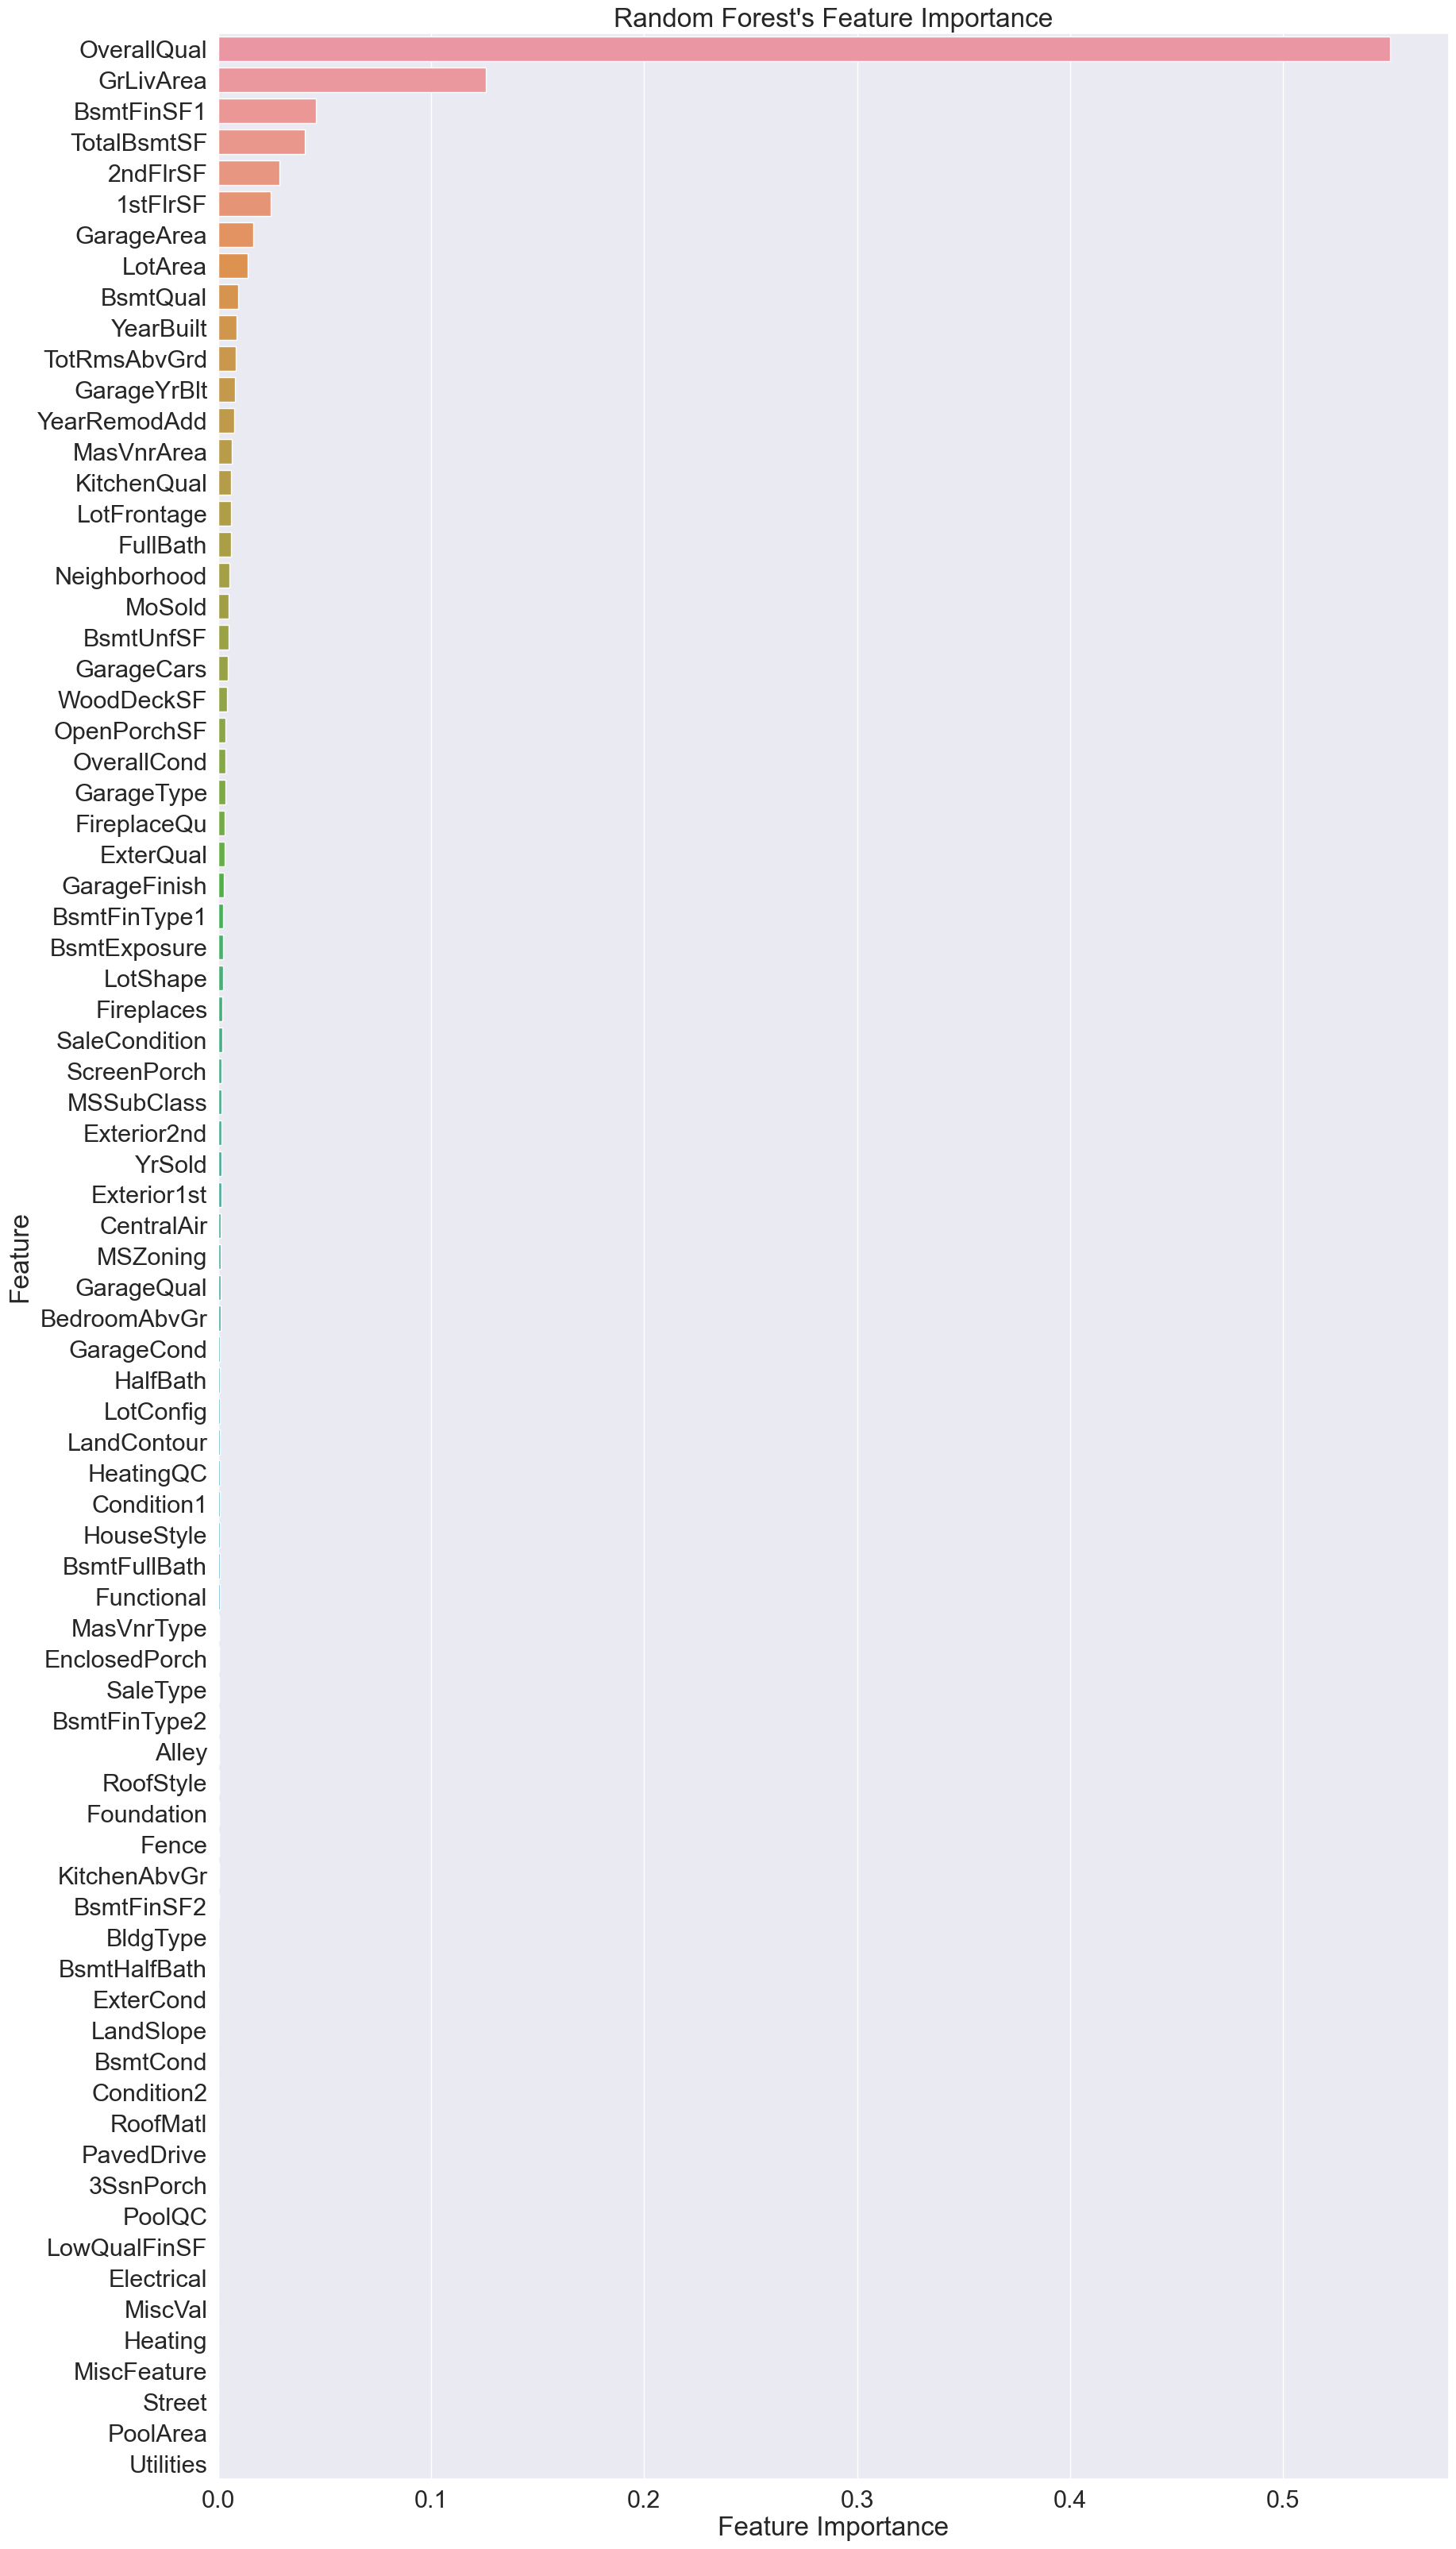

In [77]:
ModelPreprocessing.plot_feature_importance(list(X_train), rdf, 'Random Forest', (20,40))

## Training Random Forest with default parameters on significant features

In [78]:
## All the feature having importance less than GarageCond is removed (see above feature importance plot)

X_train_rdf = ModelPreprocessing.remove_insignificant_feature(X_train, rdf, 0.001)

In [79]:
rdf_feat = RandomForestRegressor(n_jobs=-1, random_state=13, verbose=1 )
rdf_feat.fit(X_train_rdf, Y_train['SalePrice'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


RandomForestRegressor(n_jobs=-1, random_state=13, verbose=1)

### Prediction on training data

In [80]:
rdf_feat_train_prd = rdf_feat.predict(X_train_rdf)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [81]:
print('Mean Absolute error on training data (on significant features) prediction with default parameters of RF:',
                      round(mean_absolute_error(Y_train, rdf_feat_train_prd), 2))

Mean Absolute error on training data (on significant features) prediction with default parameters of RF: 6680.14


### Prediction on Validation data

In [82]:
X_vaild_rdf = ModelPreprocessing.remove_insignificant_feature(X_vaild, rdf, 0.001)
rdf_feat_valid_prd = rdf_feat.predict(X_vaild_rdf)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [83]:
print('Mean Absolute error on validation data (on significant features) prediction with default parameters of RF:',
                      round(mean_absolute_error(Y_valid, rdf_feat_valid_prd), 2))

Mean Absolute error on validation data (on significant features) prediction with default parameters of RF: 16550.86


## Hyperparameter Tunning for Random Forst on significant features

In [84]:
from sklearn.model_selection import GridSearchCV

param = {'n_estimators': [350, 400, 450, 500, 550, 600],
         'max_features': [0.2, 0.3, 0.4, 'sqrt'],
         'max_depth': [5, 6, 7, 8],
         'max_leaf_nodes': [21, 22, 23, 24, 25, 26],
         'min_samples_split': [1, 2, 3, 4]}

rf_grid = GridSearchCV(estimator=RandomForestRegressor(),
                       param_grid=param,
                       scoring='neg_mean_absolute_error',
                       n_jobs=-1,
                       verbose=10,
                       cv=5)

In [85]:
rf_grid.fit(X_train_rdf, Y_train['SalePrice'])

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8],
                         'max_features': [0.2, 0.3, 0.4, 'sqrt'],
                         'max_leaf_nodes': [21, 22, 23, 24, 25, 26],
                         'min_samples_split': [1, 2, 3, 4],
                         'n_estimators': [350, 400, 450, 500, 550, 600]},
             scoring='neg_mean_absolute_error', verbose=10)

In [86]:
rf_grid.best_params_

{'max_depth': 6,
 'max_features': 0.3,
 'max_leaf_nodes': 22,
 'min_samples_split': 2,
 'n_estimators': 400}

In [87]:
# Training Random Forest on best possible parameteric value obtain after Hyperparameter Tunning

rdf_bf = RandomForestRegressor(n_estimators=400,
                               max_features=0.3,
                               max_depth=6,
                               max_leaf_nodes=22,
                               min_samples_split=2,
                               n_jobs=-1,
                               random_state=17,
                               verbose=1)

rdf_bf.fit(X_train_rdf, Y_train['SalePrice'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    1.3s finished


RandomForestRegressor(max_depth=6, max_features=0.3, max_leaf_nodes=22,
                      n_estimators=400, n_jobs=-1, random_state=17, verbose=1)

### Prediction on training data

In [88]:
rdf_bf_train_pred = rdf_bf.predict(X_train_rdf)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.1s finished


In [89]:
print('Mean Absolute error on training data (on significant features) prediction with best fit parameters of RF:',
                      round(mean_absolute_error(Y_train, rdf_bf_train_pred), 2))

Mean Absolute error on training data (on significant features) prediction with best fit parameters of RF: 17160.58


### Prediction on Validation data

In [90]:
rdf_bf_valid_pred = rdf_bf.predict(X_vaild_rdf)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.1s finished


In [91]:
print('Mean Absolute error on validation data (on significant) prediction with best fit parameters of RF:',
                      round(mean_absolute_error(Y_valid, rdf_bf_valid_pred), 2))

Mean Absolute error on validation data (on significant) prediction with best fit parameters of RF: 18696.04


#### The Mean Absolute Error on Validation data prediction after Hyperparameter Tunning for Random Forest is more than with default Parameters. But the error has also increased for Training data, which means the Optimised model is better in genralising the overall trend in data.

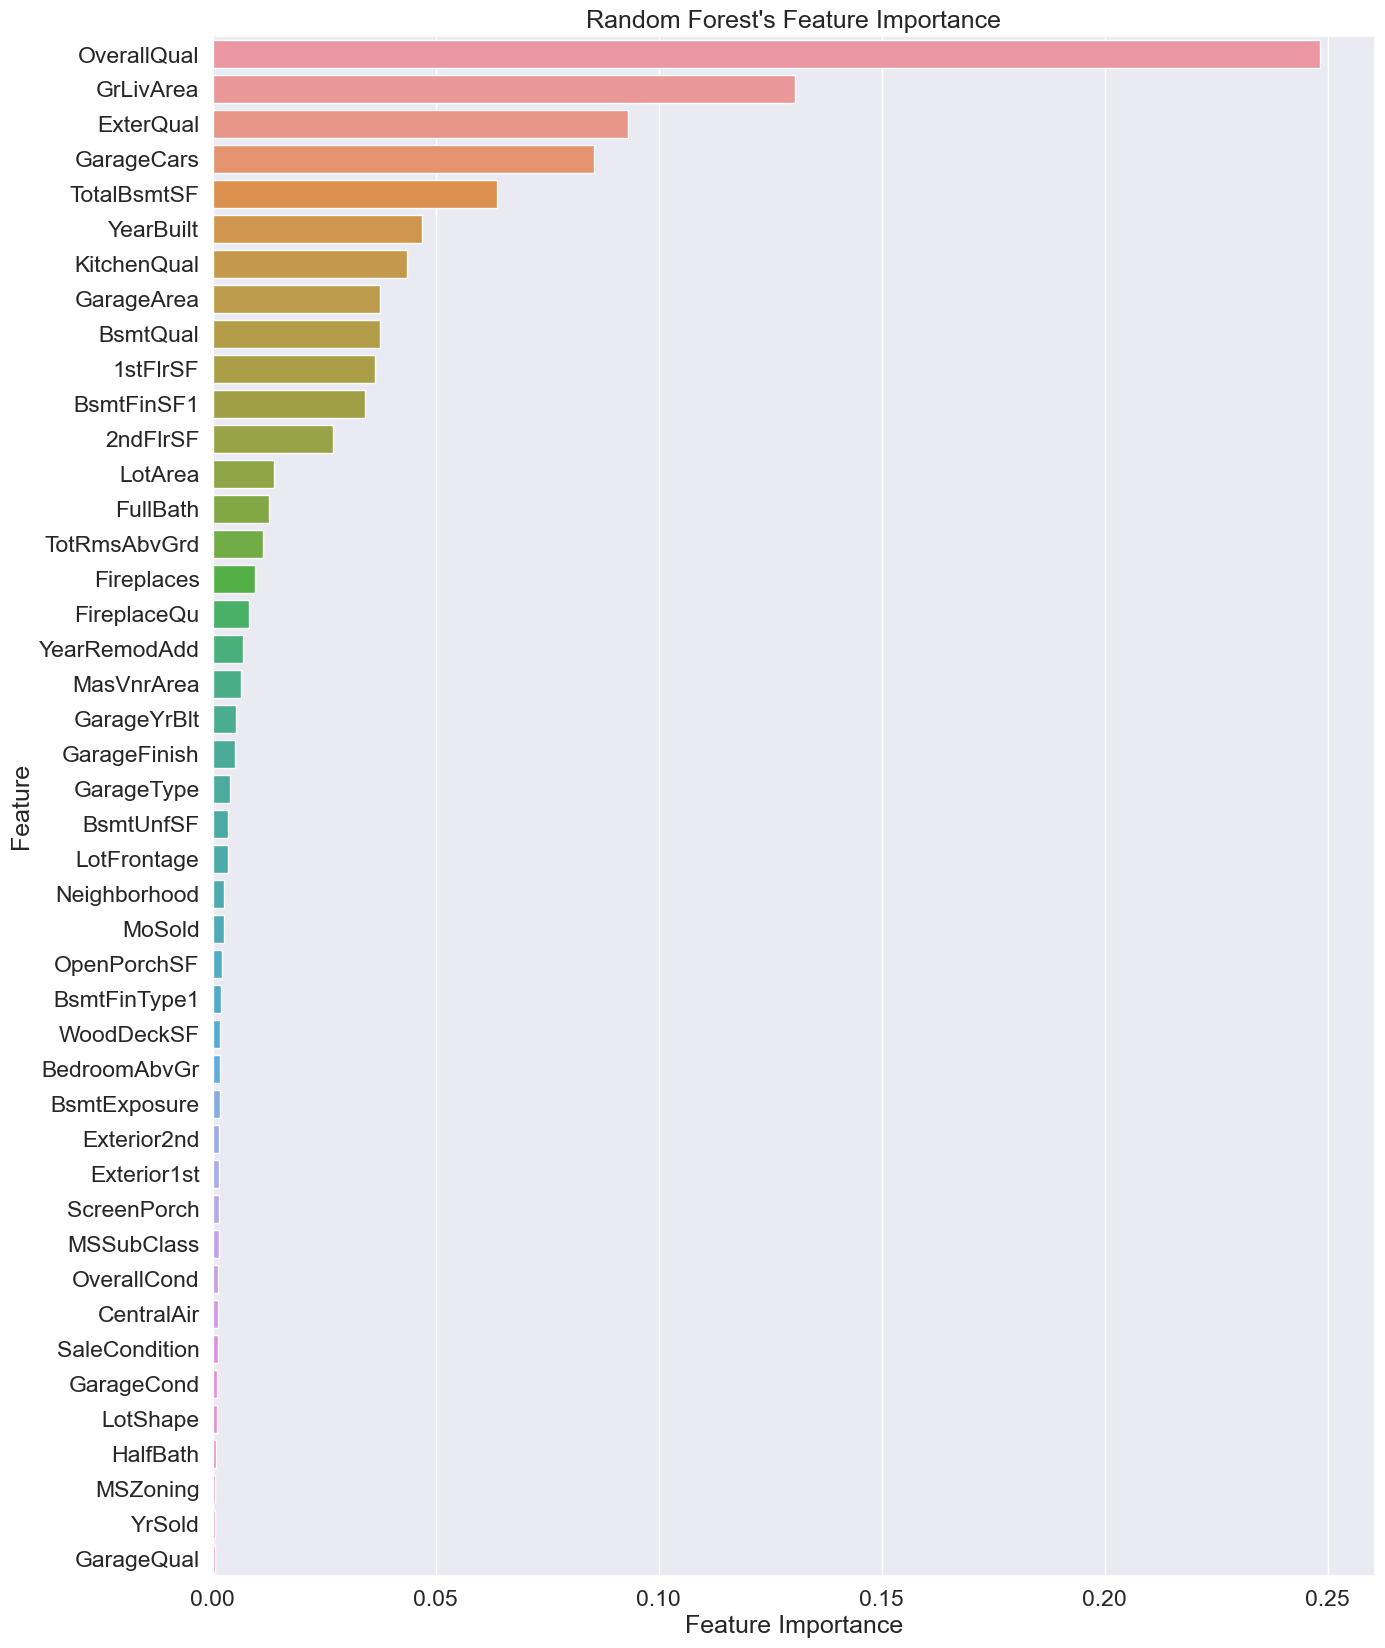

In [92]:
ModelPreprocessing.plot_feature_importance(list(X_train_rdf), rdf_bf, 'Random Forest', (15, 20), 1.5)

## XGBoost

In [93]:
from xgboost import XGBRegressor
xgb = XGBRegressor(tree_method='gpu_hist', random_state=19)

In [94]:
xgb.fit(X_train, Y_train['SalePrice'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=19, ...)

### Prediction on training data

In [95]:
xgb_train_pred = xgb.predict(X_train)
print('Mean Absolute error on training data prediction with default parameters of XGBoost:',
               round(mean_absolute_error(Y_train, xgb_train_pred), 2))

Mean Absolute error on training data prediction with default parameters of XGBoost: 608.19


### Prediction on Validation data

In [96]:
xgb_valid_pred = xgb.predict(X_vaild)
print('Mean Absolute error on validation data prediction with default parameters of XGBoost:',
               round(mean_absolute_error(Y_valid, xgb_valid_pred), 2))

Mean Absolute error on validation data prediction with default parameters of XGBoost: 16416.17


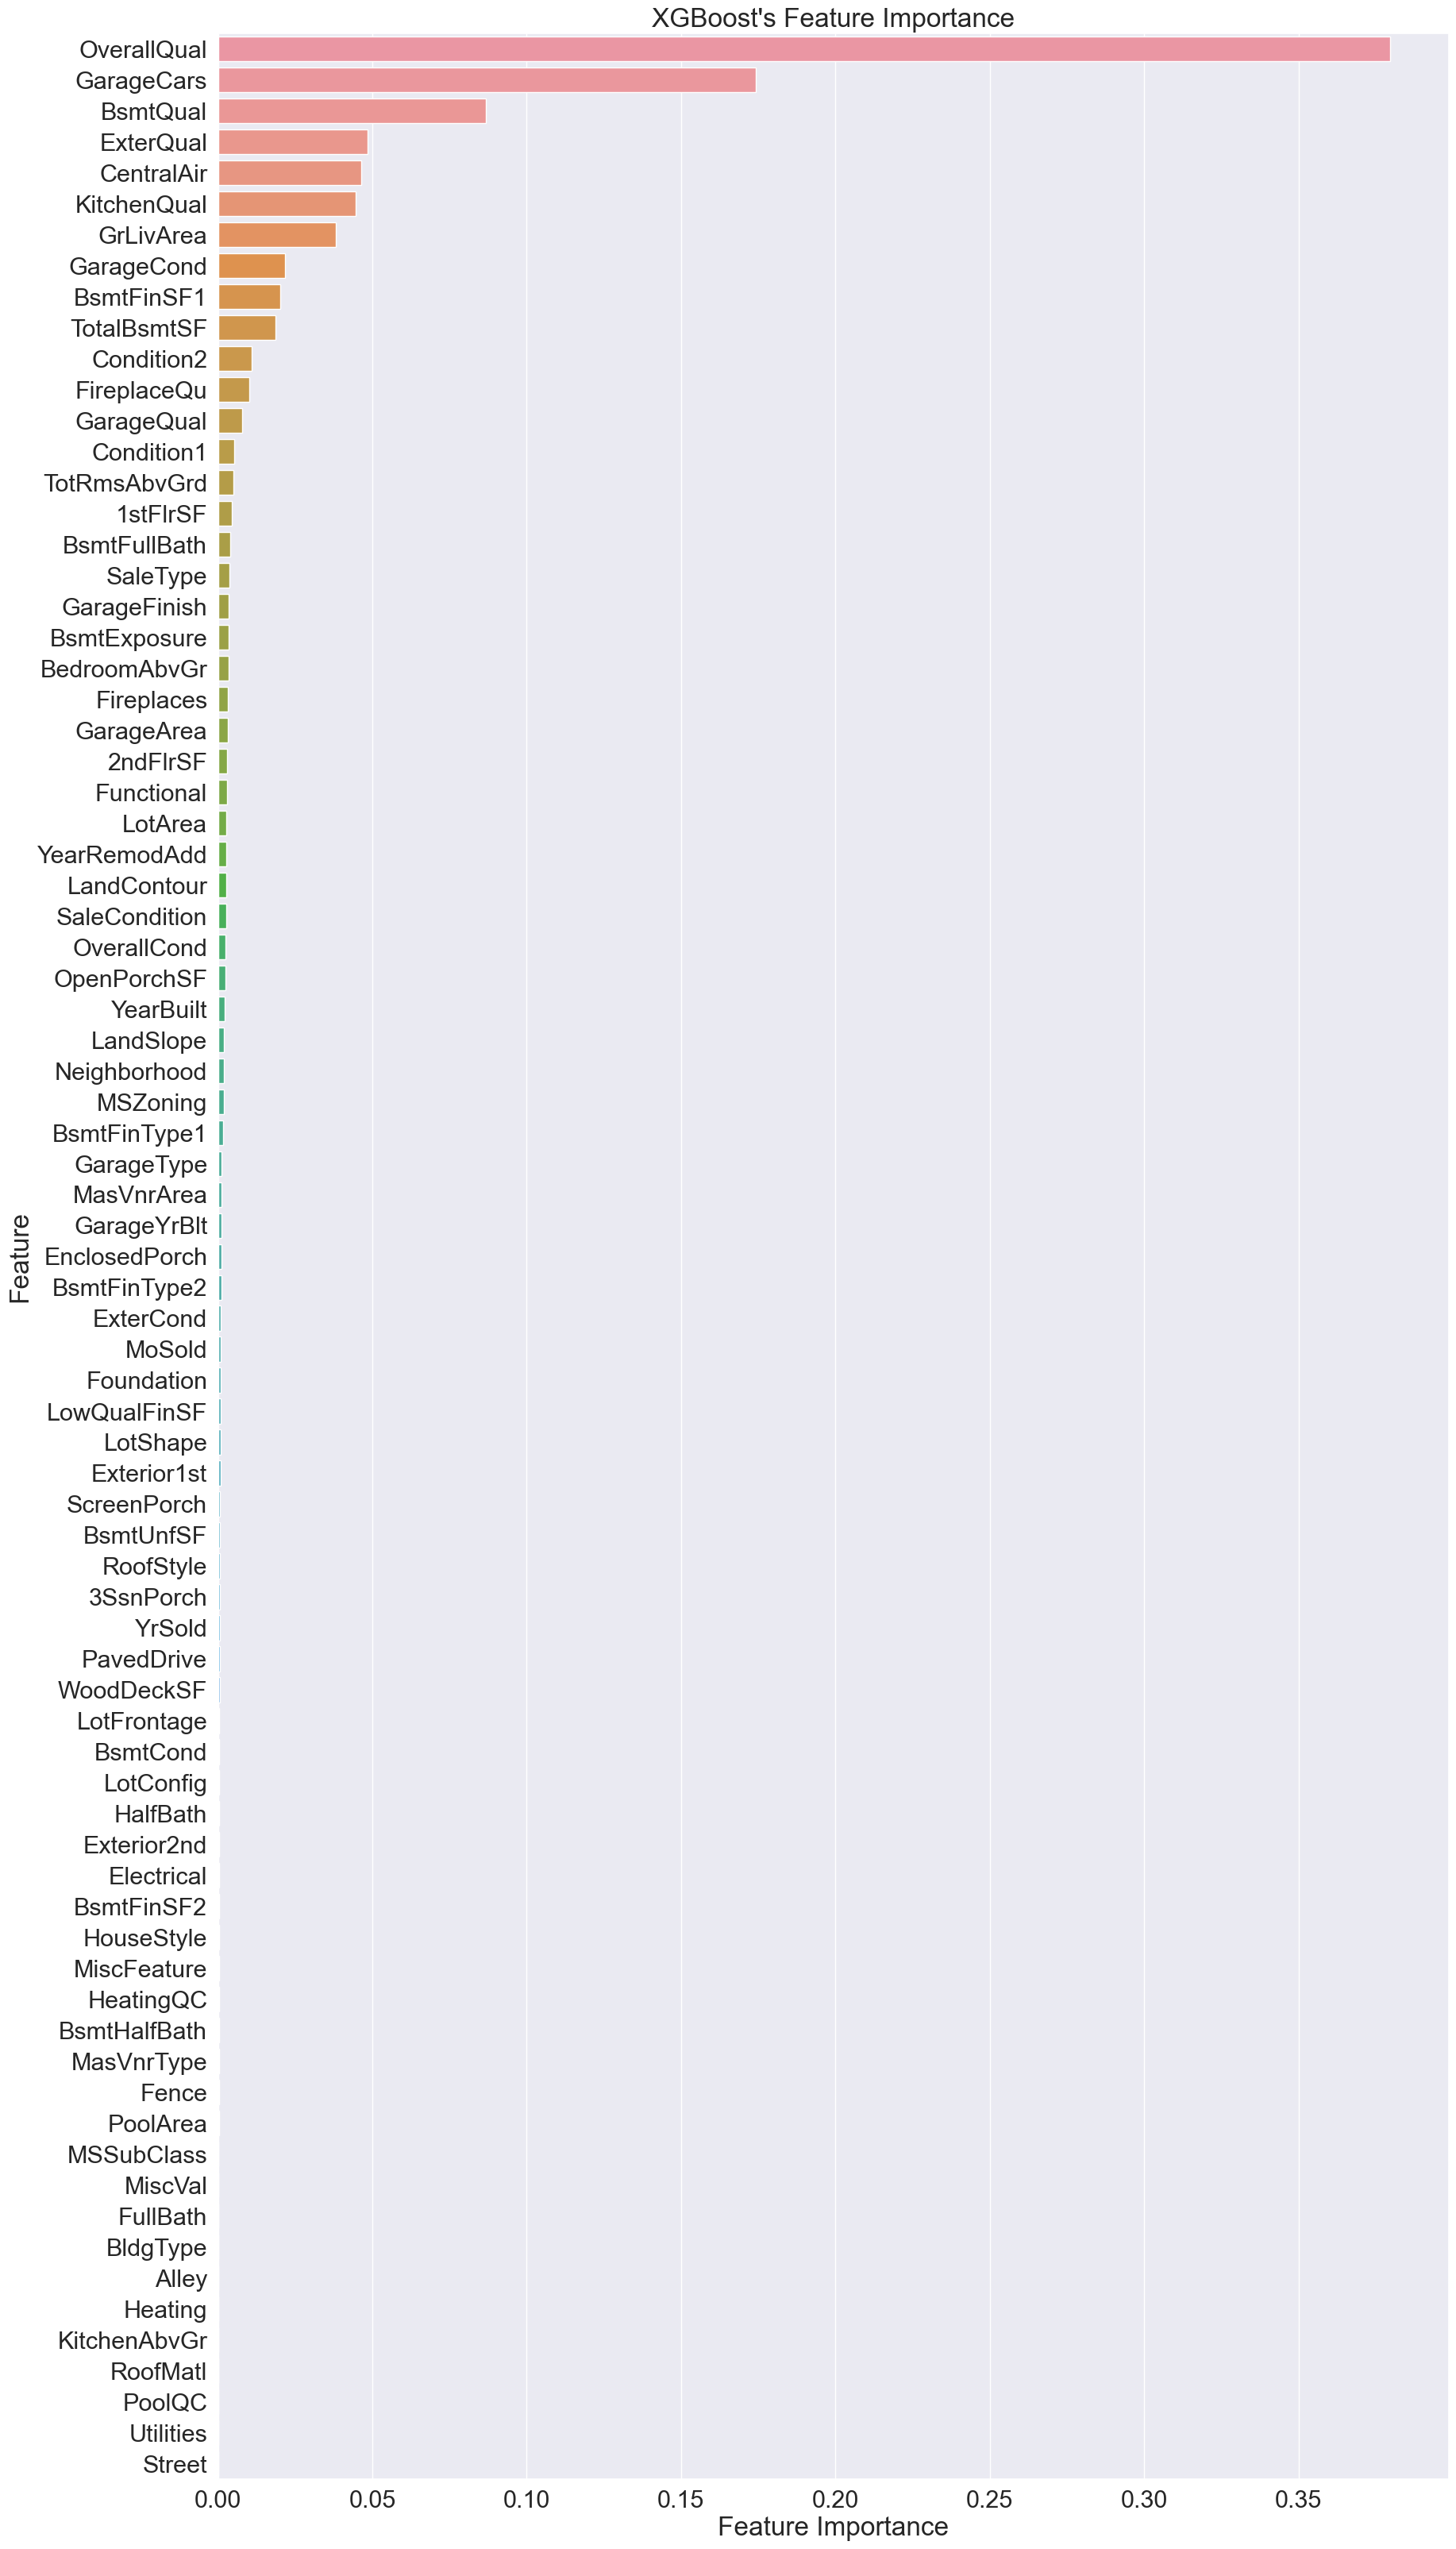

In [97]:
ModelPreprocessing.plot_feature_importance(list(X_train), xgb, 'XGBoost', (20,40))

## Training Random Forest with default parameters on significant features

In [98]:
## Removing features having feature imortance less than LandSlope (see the above plot)

X_train_xgb = ModelPreprocessing.remove_insignificant_feature(X_train, xgb, 0.002)

In [99]:
xgb_feat = XGBRegressor(tree_method='gpu_hist', random_state=21)
xgb_feat.fit(X_train_xgb, Y_train['SalePrice'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=21, ...)

### Prediction on training data

In [100]:
xgb_feat_train_pred = xgb_feat.predict(X_train_xgb)
print('Mean Absolute error on training data (on significant features) prediction with default parameters of XGBoost:',
               round(mean_absolute_error(Y_train, xgb_feat_train_pred), 2))

Mean Absolute error on training data (on significant features) prediction with default parameters of XGBoost: 910.79


### Prediction on Validation data

In [101]:
## Removing Insignificant features for Validation data
X_vaild_xgb = ModelPreprocessing.remove_insignificant_feature(X_vaild, xgb, 0.002)

In [102]:
xgb_feat_valid_pred = xgb_feat.predict(X_vaild_xgb)
print('Mean Absolute error on validation data (on significant features) prediction with default parameters of XGBoost:',
               round(mean_absolute_error(Y_valid, xgb_feat_valid_pred), 2))

Mean Absolute error on validation data (on significant features) prediction with default parameters of XGBoost: 15624.92


## HyperParameter Tunning for XGBoost on SIgnificant features

In [103]:
xgb_param = {'n_estimators': [250, 300, 350, 400, 450],
             'learning_rate': [0.07, 0.08, 0.09, 0.1, 0.2],
             'max_depth': [2, 3, 4, 5],
             'subsample': [0.7, 0.8, 0.9],
             'colsample_bytree': [0.3, 0.4, 0.5]}

xgb_grid = GridSearchCV(estimator=XGBRegressor(tree_method='gpu_hist'),
                        param_grid=xgb_param,
                        scoring='neg_mean_absolute_error',
                        n_jobs=-1,
                        verbose=10,
                        cv=5)

In [104]:
xgb_grid.fit(X_train_xgb, Y_train['SalePrice'])

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.4, 0.5],
                         'learning_rate': [0.07, 0.08, 0.09, 0.1, 0.2],
                         'max_depth': [2, 3, 4, 5],
                         'n_estimators': [250, 300, 350, 400, 450],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='neg_mean_absolute_error', verbose=10)

In [105]:
xgb_grid.best_params_

{'colsample_bytree': 0.4,
 'learning_rate': 0.09,
 'max_depth': 4,
 'n_estimators': 300,
 'subsample': 0.8}

In [106]:
# Training XGBoost on best possible parameteric value obtained after Hyperparameter Tunning

xgb_bf = XGBRegressor(n_estimators=300,
                      learning_rate=0.09,
                      max_depth=4,
                      colsample_bytree=0.4,
                      subsample=0.8,
                      random_state=23,
                      tree_method='gpu_hist')

xgb_bf.fit(X_train_xgb, Y_train['SalePrice'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=23, ...)

### Prediction on training data

In [107]:
xgb_bf_train_pred = xgb_bf.predict(X_train_xgb)
print('Mean Absolute error on training data prediction (on significant features) with best fit parameters of XGBoost:',
               round(mean_absolute_error(Y_train, xgb_bf_train_pred), 2))

Mean Absolute error on training data prediction (on significant features) with best fit parameters of XGBoost: 5319.28


### Prediction on Validation data

In [108]:
xgb_bf_valid_pred = xgb_bf.predict(X_vaild_xgb)
print('Mean Absolute error on validation data prediction (on significant features) with best fir parameters of XGBoost:',
               round(mean_absolute_error(Y_valid, xgb_bf_valid_pred), 2))

Mean Absolute error on validation data prediction (on significant features) with best fir parameters of XGBoost: 14559.94
